## Final Project Submission

Please fill out:
* Student name: David Bartholomew
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL:


# Terry Stops in Seattle: Predicting Arrests as a Result of a Terry Stop

This project involves an iterative approach to building a classification model to predict arrests as a result of Terry Stops, utilizing Terry Stop data in Seattle, WA, with reports starting in 2015. The description of the data is pulled directly from https://www.seattle.gov/police/information-and-data/terry-stops and is as follows: "[The data includes] police-civilian contacts that involve the stop and limited detention of an individual (Terry stop). Under Terry v. Ohio, 392 U.S. 1 (1968), such contacts authorized under law and policy for purposes of investigating, based on an officer's reasonable suspicion, whether the individual is engaging, has engaged, or is about to engage in criminal activity.   During the course of a Terry stop, an officer may develop probable cause to effect an arrest, but probable cause is not required to make the initial stop, nor does a stop that is based on probable cause to arrest fall within the category of a Terry stop."


The project follows the OSEMN approach as outlined below:

### 1. Obtain Data

The data for this project was obtained directly from https://catalog.data.gov/dataset/terry-stops, downloaded as a csv file and imported into a pandas dataframe. The column descriptions are available in the github repo for this project as an md file.

### 2. Scrub Data

Scrubbing the data involved removing duplicate records, filling missing values, determining whether to keep or replace placeholder values, and converting to appropriate data types.

### 3. Explore Data

This step involved plotting all features vs. the target variable, Stop Resolution, to perform additional, necessary feature engineering, one hot encoding categorical variables, and getting an overall understanding of which features to include to begin the modeling process.

### 4. Model Data

The modeling approach was to utilize several different classification algorithms and compare scores, then implementing the Boruta algorithm for feature selection, and utilizing GridSearchCV with hyperparameter tuning to increase our score. The focus on this project was the recall score (measuring the proportion of positives that are correctly identified), with the ultimate goal of predicting arrests while minimizing false negatives.

The algorithms used are as follows: Logistic Regression, Multinomial Bayes, Decision Trees, Random Forest, Balanced Random Forest, Bagging with Decision Trees, Balanced Bagging with Decision Trees, AdaBoost, and XGBoost.

### 5. Interpreting Data

The final model was built with the XGBoost algorithm, using features selected from the Boruta algorithm and fitting our model with hyperparameter tuning. The interpretation of our model is found in the conclusion section of this notebook, and following that, a function was built to test our model.


In [1]:
import pandas as pd
import pandas.testing
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
import xgboost
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, RUSBoostClassifier
from boruta import BorutaPy

In [2]:
df = pd.read_csv('data/Terry_Stops.csv')
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44043 entries, 0 to 44042
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         44043 non-null  object
 1   Subject ID                44043 non-null  int64 
 2   GO / SC Num               44043 non-null  int64 
 3   Terry Stop ID             44043 non-null  int64 
 4   Stop Resolution           44043 non-null  object
 5   Weapon Type               44043 non-null  object
 6   Officer ID                44043 non-null  object
 7   Officer YOB               44043 non-null  int64 
 8   Officer Gender            44043 non-null  object
 9   Officer Race              44043 non-null  object
 10  Subject Perceived Race    44043 non-null  object
 11  Subject Perceived Gender  44043 non-null  object
 12  Reported Date             44043 non-null  object
 13  Reported Time             44043 non-null  object
 14  Initial Call Type     

None

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,-,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,...,11:32:00,-,-,-,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2
1,-,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,...,07:59:00,-,-,-,NaN,N,N,-,-,-
2,-,-1,20150000001516,29599,Field Contact,None,4844,1961,M,White,...,19:12:00,-,-,-,NaN,N,-,-,-,-
3,-,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,...,04:55:00,-,-,-,NaN,N,N,-,-,-
4,-,-1,20150000001739,33155,Field Contact,None,6973,1977,M,White,...,00:41:00,-,-,-,NaN,N,N,-,-,-


In [3]:
df['Subject Age Group'].value_counts()

26 - 35         14603
36 - 45          9277
18 - 25          8954
46 - 55          5658
56 and Above     2227
1 - 17           1927
-                1397
Name: Subject Age Group, dtype: int64

In [4]:
df['Subject ID'].value_counts()

-1              34689
 7726859935        19
 7727117712        12
 7753260438        11
 7727600619         9
                ...  
 13332648310        1
 8910010763         1
 7727151499         1
 7729826189         1
 13080147753        1
Name: Subject ID, Length: 7407, dtype: int64

In [5]:
#Drop Subject ID
df = df.drop(columns=['Subject ID'], axis=1)

In [6]:
df['GO / SC Num'].value_counts()

20150000190790    16
20160000378750    16
20180000134604    14
20190000441736    13
20170000132836    13
                  ..
20170000189693     1
20180000173986     1
20170000377872     1
20190000001043     1
20180000071981     1
Name: GO / SC Num, Length: 34361, dtype: int64

In [7]:
df['GO / SC Num'].isna().sum()

0

In [8]:
df['Terry Stop ID'].value_counts()

13080077761    3
15045077325    3
8677596250     2
13645398605    2
15595812669    2
              ..
171013         1
477105         1
516777         1
86813          1
131072         1
Name: Terry Stop ID, Length: 44023, dtype: int64

In [9]:
df[df['Terry Stop ID'] == 13080077761]

,Subject Age Group,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
12132,18 - 25,20200000136635,13080077761,Arrest,Blunt Object/Striking Implement,8680,1997,M,White,White,...,22:12:19,"WEAPN - GUN,DEADLY WPN (NO THRTS/ASLT/DIST)",--NARCOTICS - OTHER,911,WEST PCT 2ND W - D/M RELIEF,Y,Y,West,D,D2
12133,18 - 25,20200000136635,13080077761,Arrest,Knife/Cutting/Stabbing Instrument,8680,1997,M,White,White,...,22:12:19,"WEAPN - GUN,DEADLY WPN (NO THRTS/ASLT/DIST)",--NARCOTICS - OTHER,911,WEST PCT 2ND W - D/M RELIEF,Y,Y,West,D,D2
12134,18 - 25,20200000136635,13080077761,Arrest,Mace/Pepper Spray,8680,1997,M,White,White,...,22:12:19,"WEAPN - GUN,DEADLY WPN (NO THRTS/ASLT/DIST)",--NARCOTICS - OTHER,911,WEST PCT 2ND W - D/M RELIEF,Y,Y,West,D,D2


In [10]:
#Drop duplicates
df = df.drop_duplicates(subset=['Terry Stop ID'], keep='first')

In [11]:
df['Terry Stop ID'].value_counts()

551950    1
192741    1
556325    1
423204    1
347427    1
         ..
70327     1
188265    1
533169    1
171013    1
131072    1
Name: Terry Stop ID, Length: 44023, dtype: int64

In [12]:
df['Stop Resolution'].value_counts()


Field Contact               17524
Offense Report              14971
Arrest                      10630
Referred for Prosecution      728
Citation / Infraction         170
Name: Stop Resolution, dtype: int64

Since the Stop Resolution column is a report of the resolution of the Terry Stop by the police officer, we will use this column as our target variable. We need to change this to a binary column, whether a suspect was arrested or not as reported by the police officer.

In [13]:
#Change Stop Resolution to binary: arrested or not
df['Stop Resolution'] = df['Stop Resolution'].replace('Arrest', 1.0)
df['Stop Resolution'] = df['Stop Resolution'].map(lambda x: 0.0 if (x != 1.0) else 1.0)

In [14]:
df['Stop Resolution'].value_counts()

0.0    33393
1.0    10630
Name: Stop Resolution, dtype: int64

In [15]:
df['Weapon Type'].value_counts()

None                                 32565
-                                     8934
Lethal Cutting Instrument             1482
Knife/Cutting/Stabbing Instrument      449
Handgun                                273
Firearm Other                          100
Blunt Object/Striking Implement         61
Club, Blackjack, Brass Knuckles         49
Firearm                                 31
Firearm (unk type)                      15
Mace/Pepper Spray                       14
Other Firearm                           13
Club                                     9
Rifle                                    7
None/Not Applicable                      6
Taser/Stun Gun                           5
Fire/Incendiary Device                   3
Shotgun                                  3
Automatic Handgun                        2
Brass Knuckles                           1
Blackjack                                1
Name: Weapon Type, dtype: int64

In [16]:
#Change Weapon Type to binary
df['Weapon Type'] = df['Weapon Type'].replace('-', 'None')
df['Weapon Type'] = df['Weapon Type'].replace('None/Not Applicable', 'None')

In [17]:
df['Weapon Type'].value_counts()

None                                 41505
Lethal Cutting Instrument             1482
Knife/Cutting/Stabbing Instrument      449
Handgun                                273
Firearm Other                          100
Blunt Object/Striking Implement         61
Club, Blackjack, Brass Knuckles         49
Firearm                                 31
Firearm (unk type)                      15
Mace/Pepper Spray                       14
Other Firearm                           13
Club                                     9
Rifle                                    7
Taser/Stun Gun                           5
Shotgun                                  3
Fire/Incendiary Device                   3
Automatic Handgun                        2
Brass Knuckles                           1
Blackjack                                1
Name: Weapon Type, dtype: int64

In [18]:
df['Officer ID'].value_counts()

7456      390
7634      337
7773      301
7765      299
7758      299
         ... 
6983        1
6782        1
4996        1
5833        1
6830        1
Name: Officer ID, Length: 1165, dtype: int64

In [19]:
df['Officer ID'].isna().sum()

0

In [20]:
df['Officer YOB'].value_counts()

1986    3111
1987    2827
1984    2634
1991    2545
1985    2405
1992    2214
1990    2074
1988    1936
1989    1890
1982    1792
1983    1641
1979    1417
1981    1337
1993    1301
1971    1201
1978    1098
1977     966
1976     963
1995     925
1973     890
1980     776
1994     763
1967     703
1968     615
1970     567
1974     538
1969     528
1975     519
1962     452
1996     435
1965     412
1972     410
1964     408
1997     287
1963     253
1966     222
1958     218
1961     206
1959     174
1960     159
1954      44
1957      43
1953      32
1900      26
1955      21
1956      17
1948      11
1952       9
1949       5
1946       2
1951       1
Name: Officer YOB, dtype: int64

In [21]:
df['Officer Gender'].value_counts()

M    39040
F     4972
N       11
Name: Officer Gender, dtype: int64

In [22]:
df = df[df['Officer Gender'] != 'N']

In [23]:
df['Officer Gender'].replace('M', 1.0, inplace=True)
df['Officer Gender'].replace('F', 0.0, inplace=True)

In [24]:
df['Officer Gender'].value_counts()

1.0    39040
0.0     4972
Name: Officer Gender, dtype: int64

In [25]:
df['Officer Race'].value_counts()

White                            33766
Hispanic or Latino                2495
Two or More Races                 2324
Asian                             1805
Black or African American         1756
Not Specified                     1105
Nat Hawaiian/Oth Pac Islander      435
American Indian/Alaska Native      311
Unknown                             15
Name: Officer Race, dtype: int64

In [26]:
df['Initial Call Type'].value_counts()

-                                                 12839
SUSPICIOUS STOP - OFFICER INITIATED ONVIEW         2845
SUSPICIOUS PERSON, VEHICLE OR INCIDENT             2761
DISTURBANCE, MISCELLANEOUS/OTHER                   2272
ASLT - IP/JO - WITH OR W/O WPNS (NO SHOOTINGS)     1861
                                                  ...  
DEMONSTRATIONS                                        1
ALARM - ATM MACHINE, FREE STANDING                    1
REQUEST TO WATCH                                      1
PHONE - OBSCENE OR NUISANCE PHONE CALLS               1
PROPERTY - FOUND GUN, SHELLCASINGS                    1
Name: Initial Call Type, Length: 164, dtype: int64

In [27]:
df['Final Call Type'].value_counts()

-                                                     12839
--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON               3408
--PROWLER - TRESPASS                                   3059
--DISTURBANCE - OTHER                                  2511
--ASSAULTS, OTHER                                      2138
                                                      ...  
-ASSIGNED DUTY - FOOT BEAT (FROM ASSIGNED CAR)            1
BIAS -RACIAL, POLITICAL, SEXUAL MOTIVATION                1
-OFF DUTY EMPLOYMENT                                      1
--DIRECTED PATROL ACTIVITY                                1
ASSIST PUBLIC - NO WELFARE CHK OR DV ORDER SERVICE        1
Name: Final Call Type, Length: 201, dtype: int64

Since the Final Call Type column includes arrest information that was reported by the officer after the Terry Stop, we need to drop this column as it is biased information after the stop.

In [28]:
df = df.drop(columns=['Final Call Type'], axis=1)

In [29]:
df['Officer Race'].value_counts()

White                            33766
Hispanic or Latino                2495
Two or More Races                 2324
Asian                             1805
Black or African American         1756
Not Specified                     1105
Nat Hawaiian/Oth Pac Islander      435
American Indian/Alaska Native      311
Unknown                             15
Name: Officer Race, dtype: int64

In [30]:
df['Officer Race'] = df['Officer Race'].replace('Unknown', 'Not Specified')
df['Officer Race'].value_counts()

White                            33766
Hispanic or Latino                2495
Two or More Races                 2324
Asian                             1805
Black or African American         1756
Not Specified                     1120
Nat Hawaiian/Oth Pac Islander      435
American Indian/Alaska Native      311
Name: Officer Race, dtype: int64

In [31]:
df['Subject Perceived Race'].value_counts()

White                                        21520
Black or African American                    13132
Unknown                                       2293
-                                             1699
Hispanic                                      1684
Asian                                         1396
American Indian or Alaska Native              1288
Multi-Racial                                   809
Other                                          152
Native Hawaiian or Other Pacific Islander       39
Name: Subject Perceived Race, dtype: int64

In [32]:
df['Subject Perceived Race'] = df['Subject Perceived Race'].replace('-', 'Unknown')
df['Subject Perceived Race'] = df['Subject Perceived Race'].replace('Other', 'Unknown')
df['Subject Perceived Race'].value_counts()

White                                        21520
Black or African American                    13132
Unknown                                       4144
Hispanic                                      1684
Asian                                         1396
American Indian or Alaska Native              1288
Multi-Racial                                   809
Native Hawaiian or Other Pacific Islander       39
Name: Subject Perceived Race, dtype: int64

In [33]:
df['Subject Perceived Gender'].value_counts()

Male                                                         34395
Female                                                        9010
Unable to Determine                                            326
-                                                              263
Unknown                                                         14
Gender Diverse (gender non-conforming and/or transgender)        4
Name: Subject Perceived Gender, dtype: int64

In [34]:
#Drop unknown and smaller categories
df = df[(df['Subject Perceived Gender'] == 'Male') | (df['Subject Perceived Gender'] == 'Female')]

In [35]:
df['Subject Perceived Gender'].value_counts()

Male      34395
Female     9010
Name: Subject Perceived Gender, dtype: int64

In [36]:
#Map 'M' and 'F' to 1 and 0
df['Subject Perceived Gender'] = df['Subject Perceived Gender'].map({'Male': 1.0, 'Female': 0.0})

In [37]:
df['Subject Perceived Gender'].value_counts()

1.0    34395
0.0     9010
Name: Subject Perceived Gender, dtype: int64

In [38]:
df['Reported Date'].value_counts()

2015-10-01T00:00:00    91
2015-09-29T00:00:00    66
2015-05-28T00:00:00    57
2015-08-04T00:00:00    53
2019-04-26T00:00:00    53
                       ..
2015-05-06T00:00:00     1
2015-03-24T00:00:00     1
2015-03-15T00:00:00     1
2015-05-13T00:00:00     1
2015-04-28T00:00:00     1
Name: Reported Date, Length: 2023, dtype: int64

In [39]:
#Split time from date and keep date in df
df['Reported Date'] = df['Reported Date'].str.split('T').str[0]

In [40]:
df['Reported Date'] = pd.to_datetime(df['Reported Date'])

In [41]:
df['Reported Day of Week'] = df['Reported Date'].dt.day_name()

In [42]:
df['Reported Year'] = df['Reported Date'].dt.year
df['Reported Month'] = df['Reported Date'].dt.month
df['Reported Day'] = df['Reported Date'].dt.day

In [43]:
df = df.drop(columns=['Reported Date'], axis=1)

In [44]:
#Convert to datetime
df['Reported Time'] = df['Reported Time'].str.split(':')
df['Reported Time'].head()

0    [11, 32, 00]
2    [19, 12, 00]
4    [00, 41, 00]
5    [23, 46, 00]
6    [21, 39, 00]
Name: Reported Time, dtype: object

In [45]:
df['Reported Hour'] = df['Reported Time'].map(lambda x: x[0]).astype('float64')
df['Reported Minute'] = df['Reported Time'].map(lambda x: x[1]).astype('float64')

In [46]:
df = df.drop(columns=['Reported Time'], axis=1)

In [47]:
df.head()

,Subject Age Group,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,...,Frisk Flag,Precinct,Sector,Beat,Reported Day of Week,Reported Year,Reported Month,Reported Day,Reported Hour,Reported Minute
0,-,20140000120677,92317,1.0,None,7500,1984,1.0,Black or African American,Asian,...,N,South,O,O2,Friday,2015,10,16,11.0,32.0
2,-,20150000001516,29599,0.0,None,4844,1961,1.0,White,White,...,-,-,-,-,Saturday,2015,3,21,19.0,12.0
4,-,20150000001739,33155,0.0,None,6973,1977,1.0,White,Black or African American,...,N,-,-,-,Friday,2015,4,3,0.0,41.0
5,-,20150000001755,33571,0.0,None,7402,1973,1.0,White,Black or African American,...,N,-,-,-,Sunday,2015,4,5,23.0,46.0
6,-,20150000002351,45252,0.0,None,7591,1985,1.0,Hispanic or Latino,Unknown,...,N,-,-,-,Wednesday,2015,5,20,21.0,39.0


In [48]:
df['Call Type'].value_counts()

911                              19281
-                                12608
ONVIEW                            8182
TELEPHONE OTHER, NOT 911          3044
ALARM CALL (NOT POLICE ALARM)      281
TEXT MESSAGE                         6
PROACTIVE (OFFICER INITIATED)        2
SCHEDULED EVENT (RECURRING)          1
Name: Call Type, dtype: int64

In [49]:
df['Officer Squad'].value_counts()

TRAINING - FIELD TRAINING SQUAD                   4622
WEST PCT 1ST W - DAVID/MARY                       1437
WEST PCT 2ND W - D/M RELIEF                        950
NORTH PCT 2ND WATCH - NORTH BEATS                  880
SOUTHWEST PCT 2ND W - FRANK                        876
                                                  ... 
VICE - GENERAL INVESTIGATIONS SQUAD                  1
RECORDS - DAY SHIFT                                  1
COMM - INTERNET AND TELEPHONE REPORTING (ITRU)       1
SOUTHWEST PCT OPS - BURG/THEFT                       1
ZOLD CRIME ANALYSIS UNIT - ANALYSTS                  1
Name: Officer Squad, Length: 158, dtype: int64

In [50]:
df['Officer Squad'].fillna('Unknown', inplace=True)

In [51]:
df['Arrest Flag'].value_counts()

N    40984
Y     2421
Name: Arrest Flag, dtype: int64

We will remove arrest flag as it would highly influence our model with data we are looking to predict.

In [52]:
df = df.drop(columns=['Arrest Flag'], axis=1)

In [53]:
df['Frisk Flag'].value_counts()

N    33384
Y     9601
-      420
Name: Frisk Flag, dtype: int64

In [54]:
df = df[df['Frisk Flag'] != '-']

In [55]:
df['Frisk Flag'] = df['Frisk Flag'].map({'Y': 1.0, 'N': 0.0})

In [56]:
df['Precinct'].value_counts()

West         10090
North         9519
-             9386
East          5691
South         5103
Southwest     2238
SouthWest      731
Unknown        184
OOJ             28
FK ERROR        15
Name: Precinct, dtype: int64

In [57]:
df['Sector'].value_counts()

-         9574
E         2262
M         2219
N         2131
K         1725
B         1631
L         1592
D         1486
R         1410
K         1345
F         1340
S         1310
U         1266
O         1117
J         1099
G         1060
C         1006
Q          948
M          947
W          897
D          869
E          758
Q          547
N          530
O          457
F          434
R          425
S          384
B          347
U          346
G          340
J          306
W          297
L          270
C          265
99          45
Name: Sector, dtype: int64

In [58]:
df['Beat'].nunique()

107

In [59]:
df.head()

,Subject Age Group,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,...,Frisk Flag,Precinct,Sector,Beat,Reported Day of Week,Reported Year,Reported Month,Reported Day,Reported Hour,Reported Minute
0,-,20140000120677,92317,1.0,None,7500,1984,1.0,Black or African American,Asian,...,0.0,South,O,O2,Friday,2015,10,16,11.0,32.0
4,-,20150000001739,33155,0.0,None,6973,1977,1.0,White,Black or African American,...,0.0,-,-,-,Friday,2015,4,3,0.0,41.0
5,-,20150000001755,33571,0.0,None,7402,1973,1.0,White,Black or African American,...,0.0,-,-,-,Sunday,2015,4,5,23.0,46.0
6,-,20150000002351,45252,0.0,None,7591,1985,1.0,Hispanic or Latino,Unknown,...,0.0,-,-,-,Wednesday,2015,5,20,21.0,39.0
7,-,20150000002363,45182,0.0,None,7591,1985,1.0,Hispanic or Latino,White,...,0.0,-,-,-,Wednesday,2015,5,20,22.0,40.0


In [60]:
#Drop unnecessary columns
df = df.drop(columns=['GO / SC Num', 'Terry Stop ID', 'Officer ID'], axis=1)

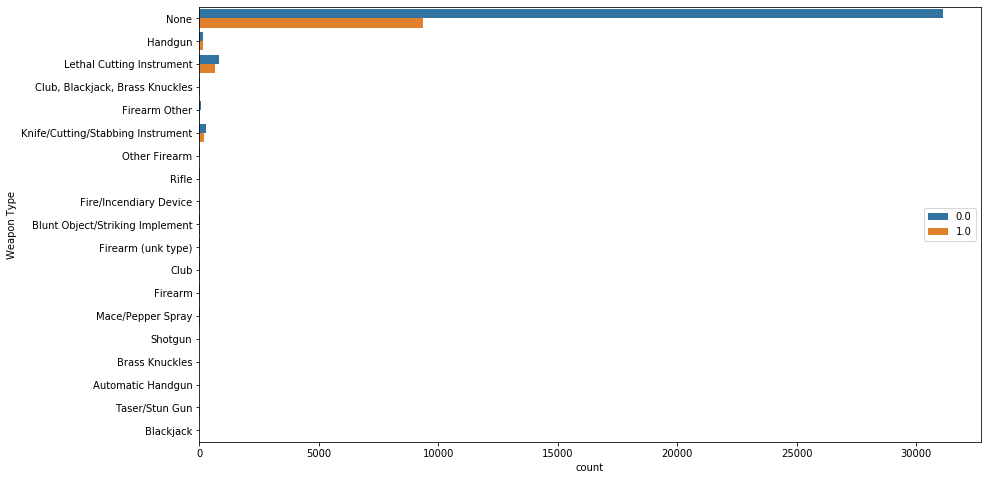

In [61]:
#Plot weapon type vs. stop resolution
plt.figure(figsize=(14, 8))
sns.countplot(y=df['Weapon Type'], hue=df['Stop Resolution'])
plt.legend(loc='center right')
plt.show()

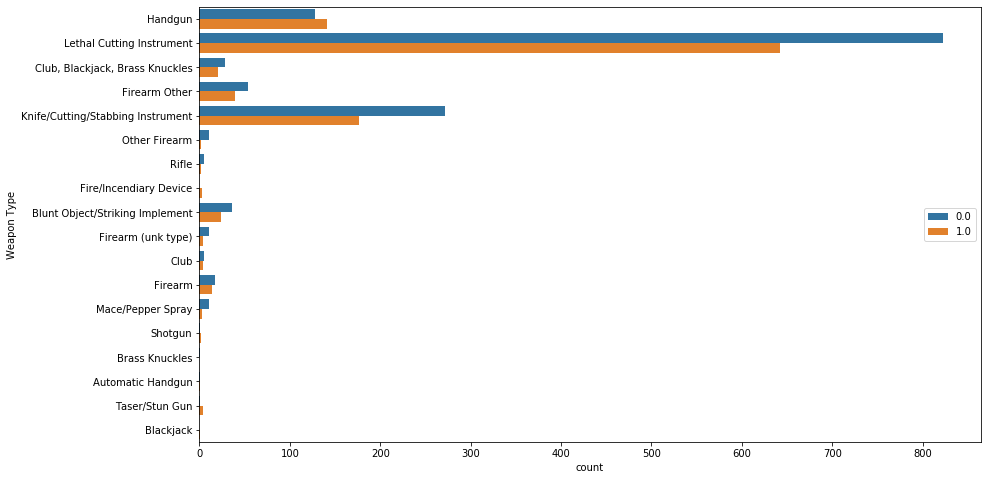

In [62]:
#Remove None from weapons to highlight those with weapons
weapon = df[(df['Weapon Type'] != 'None')]
plt.figure(figsize=(14, 8))
sns.countplot(y=weapon['Weapon Type'], hue=weapon['Stop Resolution'])
plt.legend(loc='center right')
plt.show()

In [63]:
#Bin weapon type columns to lethal cutting instrument, firearm, other
df['Weapon Type'].replace('Knife/Cutting/Stabbing Instrument', 'Lethal Cutting Instrument', inplace=True)


df['Weapon Type'].replace('Handgun', 'Firearm', inplace=True)
df['Weapon Type'].replace('Other Firearm', 'Firearm', inplace=True)
df['Weapon Type'].replace('Rifle', 'Firearm', inplace=True)
df['Weapon Type'].replace('Firearm (unk type)', 'Firearm', inplace=True)
df['Weapon Type'].replace('Shotgun', 'Firearm', inplace=True)
df['Weapon Type'].replace('Automatic Handgun', 'Firearm', inplace=True)
df['Weapon Type'].replace('Taser/Stun Gun', 'Firearm', inplace=True)
df['Weapon Type'].replace('Fire/Incendiary Device', 'Firearm', inplace=True)
df['Weapon Type'].replace('Firearm Other', 'Firearm', inplace=True)

df['Weapon Type'].replace('Club, Blackjack, Brass Knuckles', 'Other', inplace=True)
df['Weapon Type'].replace('Fire/Incendiary Device', 'Other', inplace=True)
df['Weapon Type'].replace('Blunt Object/Striking Implement', 'Other', inplace=True)
df['Weapon Type'].replace('Club', 'Other', inplace=True)
df['Weapon Type'].replace('Mace/Pepper Spray', 'Other', inplace=True)
df['Weapon Type'].replace('Brass Knuckles', 'Other', inplace=True)
df['Weapon Type'].replace('Blackjack', 'Other', inplace=True)

Convert weapon type to binary, 0: suspect does not have a weapon, 1: suspect has a weapon.

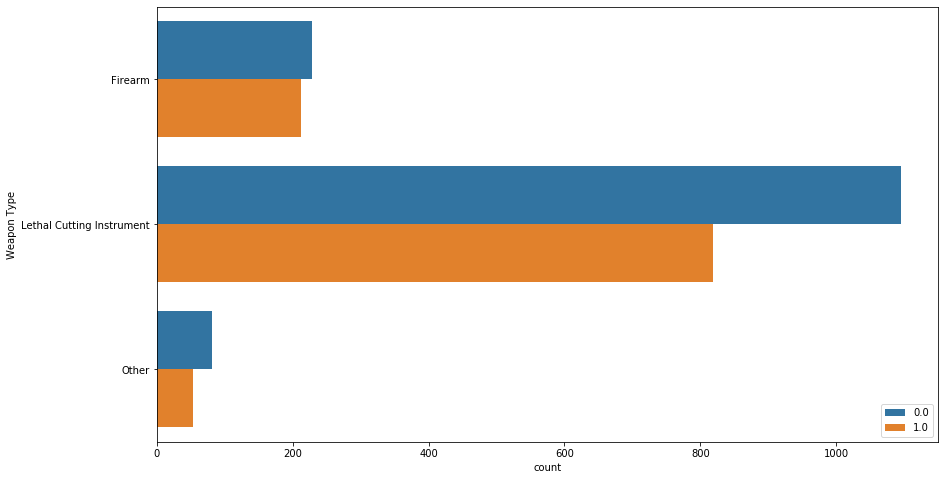

In [64]:
#Plot weapon type vs. stop resolution
weapon = df[(df['Weapon Type'] != 'None')]
plt.figure(figsize=(14, 8))
sns.countplot(y=weapon['Weapon Type'], hue=weapon['Stop Resolution'])
plt.legend(loc='lower right')
plt.show()

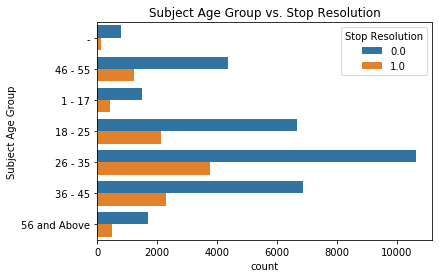

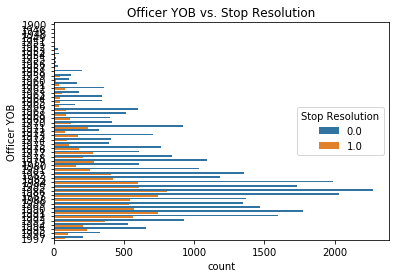

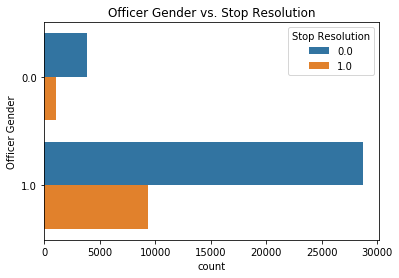

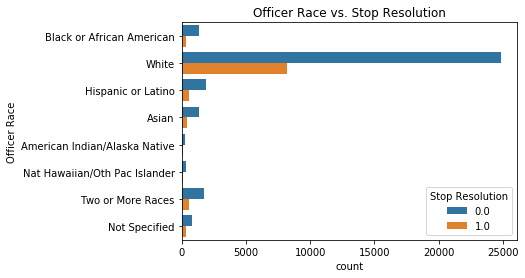

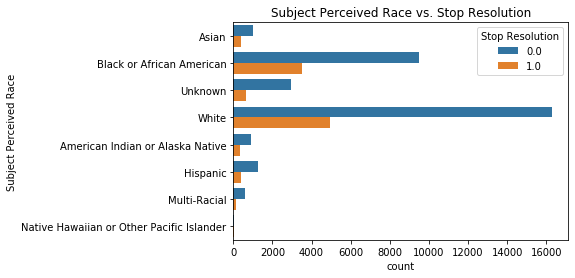

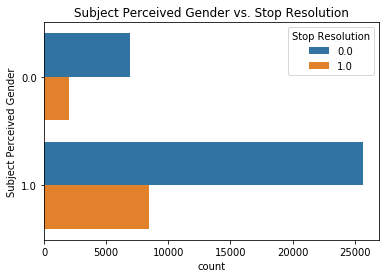

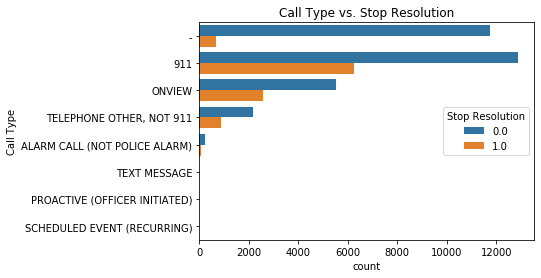

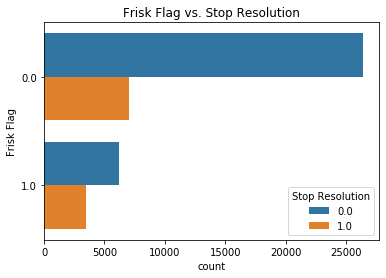

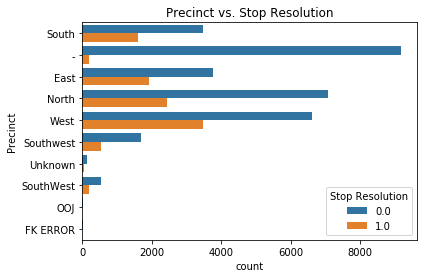

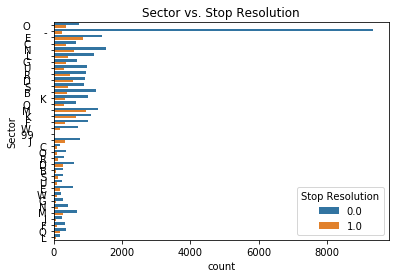

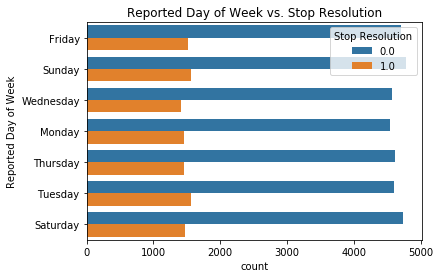

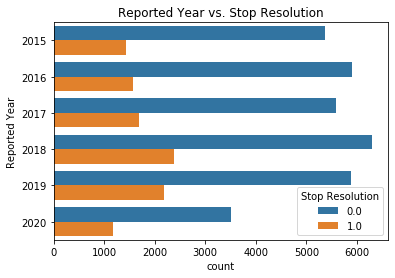

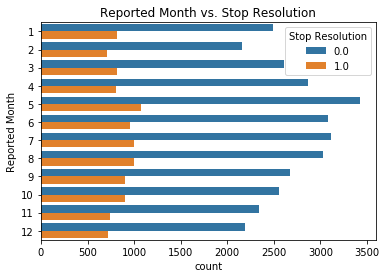

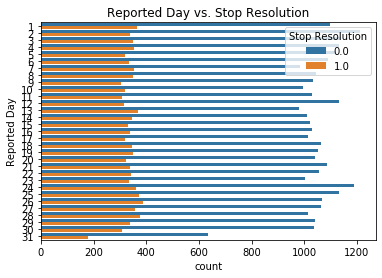

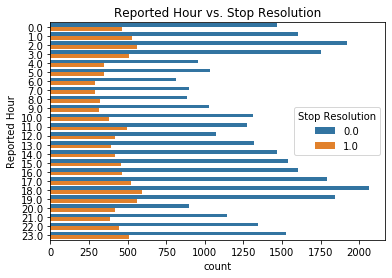

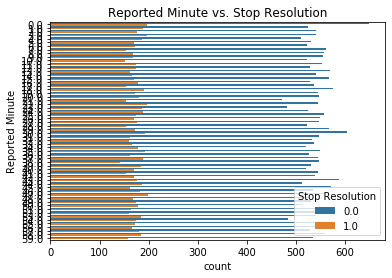

In [65]:
#Plot features vs. target, removing larger categorical variables
X = df.drop(columns=['Stop Resolution', 'Officer Squad', 'Initial Call Type', 'Weapon Type', 'Beat'], axis=1)

for col in X.columns:
    plt.subplots(1, 1)
    sns.countplot(y=X[col], hue=df['Stop Resolution'])
    plt.title('{} vs. Stop Resolution'.format(col))

In [66]:
#Convert to binary
df['Officer Race'].replace('White', 1.0, inplace=True)
values = df['Officer Race'].values
df['Officer Race'] = np.where(values != 1.0, 0.0, 1.0)

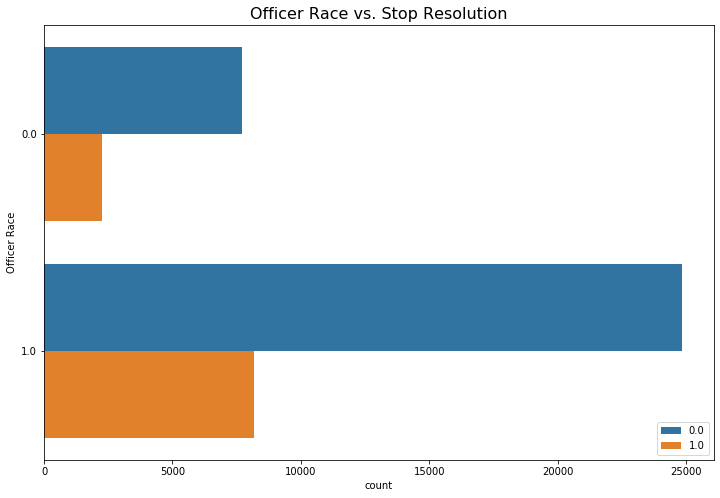

In [67]:
#Plot officer race vs. stop resolution
plt.figure(figsize=(12, 8))
sns.countplot(y=df['Officer Race'], hue=df['Stop Resolution'])
plt.title('Officer Race vs. Stop Resolution', fontsize=(16))
plt.legend(loc='lower right')
plt.show()

In [68]:
#Convert to binary
df['Subject Perceived Race'].replace('White', 1.0, inplace=True)
df['Subject Perceived Race'].replace('Black or African American', 1.0, inplace=True)
values = df['Subject Perceived Race'].values
df['Subject Perceived Race'] = np.where(values != 1.0, 0.0, 1.0)

In [69]:
#Bin categories to Other, 911, and Onview
df['Call Type'].replace('TELEPHONE OTHER, NOT 911', 'Other', inplace=True)
df['Call Type'].replace('-', 'Other', inplace=True)
df['Call Type'].replace('ALARM CALL (NOT POLICE ALARM)', 'Other', inplace=True)
df['Call Type'].replace('TEXT MESSAGE', 'Other', inplace=True)
df['Call Type'].replace('PROACTIVE (OFFICER INITIATED)', 'Other', inplace=True)
df['Call Type'].replace('SCHEDULED EVENT (RECURRING)', 'Other', inplace=True)

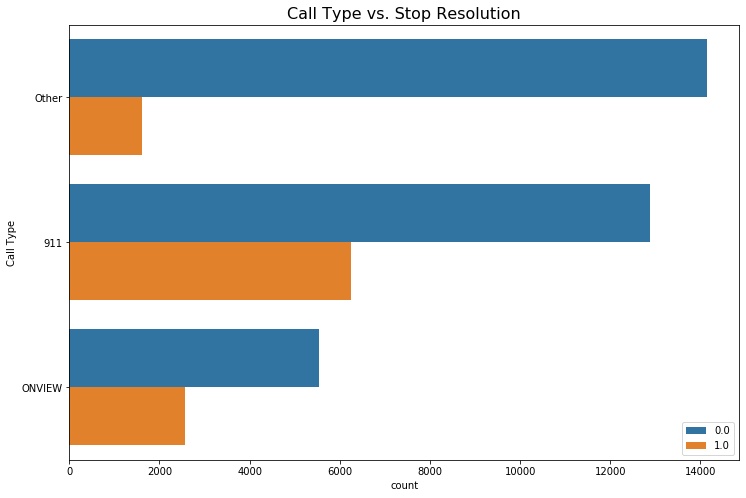

In [70]:
#Plot call type vs. stop resolution
plt.figure(figsize=(12, 8))
sns.countplot(y=df['Call Type'], hue=df['Stop Resolution'])
plt.title('Call Type vs. Stop Resolution', fontsize=(16))
plt.legend(loc='lower right')
plt.show()

In [71]:
#Convert precinct to binary
df['Precinct'].replace('South', 1.0, inplace=True)
df['Precinct'].replace('East', 1.0, inplace=True)
df['Precinct'].replace('North', 1.0, inplace=True)
df['Precinct'].replace('West', 1.0, inplace=True)
df['Precinct'].replace('Southwest', 1.0, inplace=True)
df['Precinct'].replace('SouthWest', 1.0, inplace=True)
values = df['Precinct'].values
df['Precinct'] = np.where(values != 1.0, 0.0, 1.0)

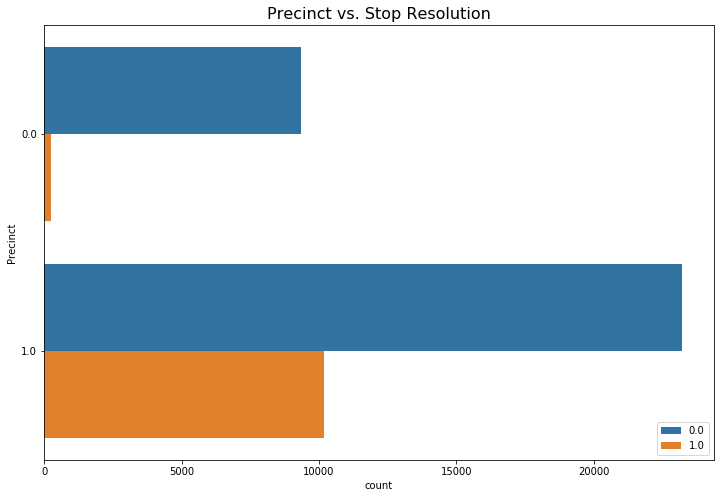

In [72]:
#Plot precinct vs. stop resolution
plt.figure(figsize=(12, 8))
sns.countplot(y=df['Precinct'], hue=df['Stop Resolution'])
plt.title('Precinct vs. Stop Resolution', fontsize=(16))
plt.legend(loc='lower right')
plt.show()

In [73]:
#Convert sector to binary
df['Sector'].replace('-', 0.0, inplace=True)
values = df['Sector'].values
df['Sector'] = np.where(values != 0.0, 1.0, 0.0)

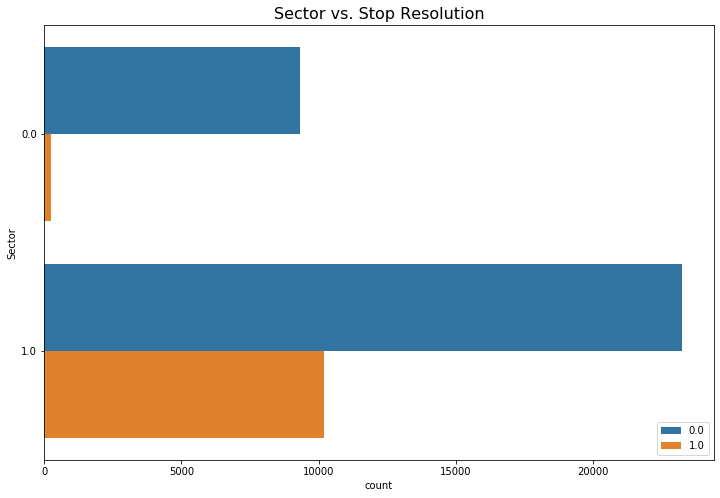

In [74]:
#Plot sector vs. stop resolution
plt.figure(figsize=(12, 8))
sns.countplot(y=df['Sector'], hue=df['Stop Resolution'])
plt.title('Sector vs. Stop Resolution', fontsize=(16))
plt.legend(loc='lower right')
plt.show()

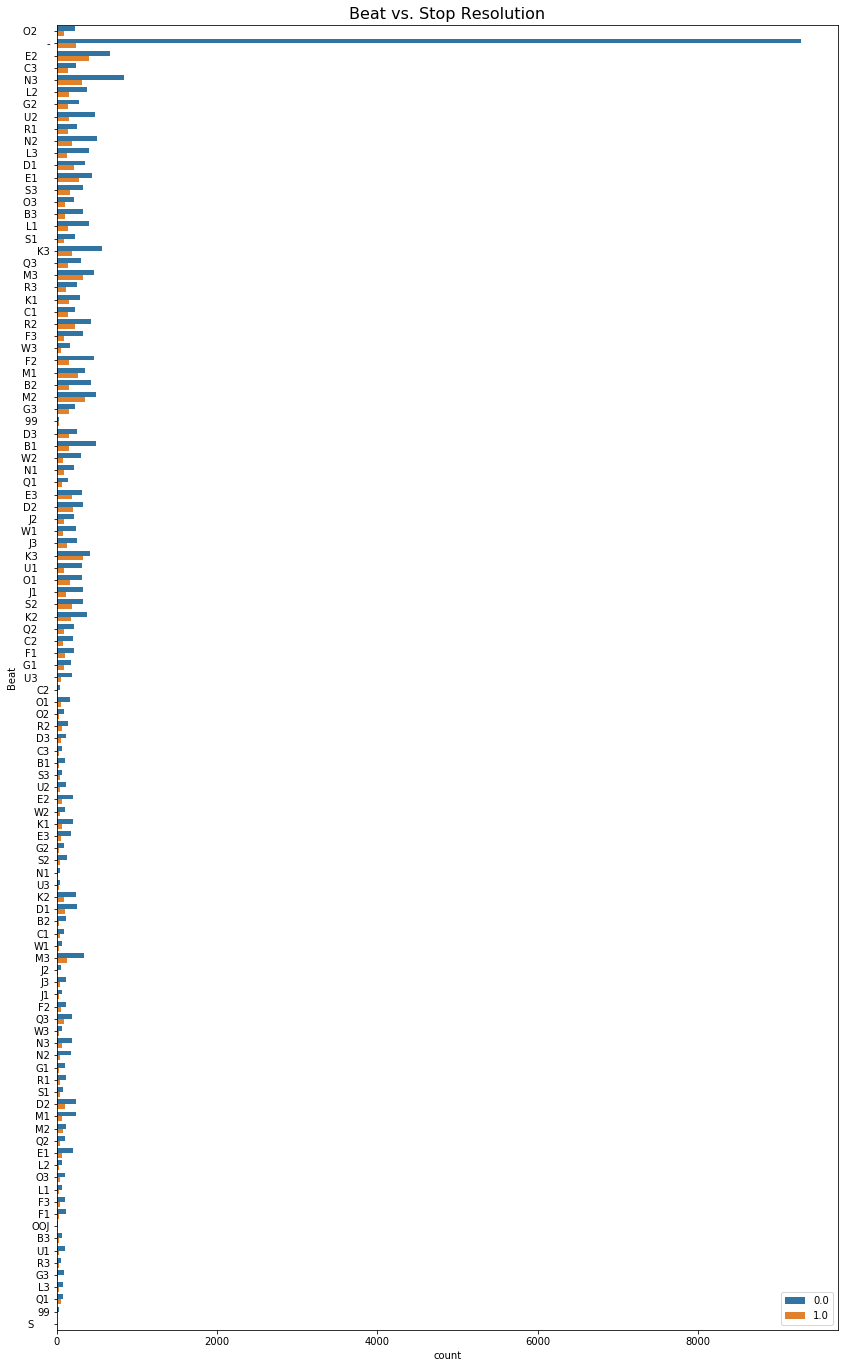

In [75]:
#Plot beat vs. stop resolution
plt.figure(figsize=(14, 24))
sns.countplot(y=df['Beat'], hue=df['Stop Resolution'])
plt.title('Beat vs. Stop Resolution', fontsize=(16))
plt.legend(loc='lower right')
plt.show()

In [76]:
#Convert beat to binary
df['Beat'].replace('-', 0.0, inplace=True)
values = df['Beat'].values
df['Beat'] = np.where(values != 0.0, 1.0, 0.0)

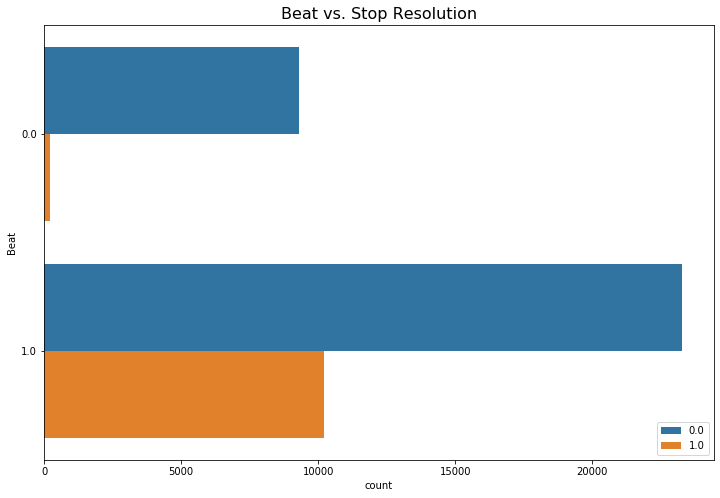

In [77]:
#Plot beat vs. stop resolution
plt.figure(figsize=(12, 8))
sns.countplot(y=df['Beat'], hue=df['Stop Resolution'])
plt.title('Beat vs. Stop Resolution', fontsize=(16))
plt.legend(loc='lower right')
plt.show()

In [78]:
#Print value counts for sector, precinct, beat
print(df.Sector.value_counts())
print(df.Precinct.value_counts())
print(df.Beat.value_counts())

1.0    33411
0.0     9574
Name: Sector, dtype: int64
1.0    33372
0.0     9613
Name: Precinct, dtype: int64
1.0    33462
0.0     9523
Name: Beat, dtype: int64


Sector, Precinct and Beat are virtually the same. We will remove Sector and Precinct since Beat has the most arrests.

In [79]:
#Drop sector and precinct
df = df.drop(columns=['Sector', 'Precinct'], axis=1)

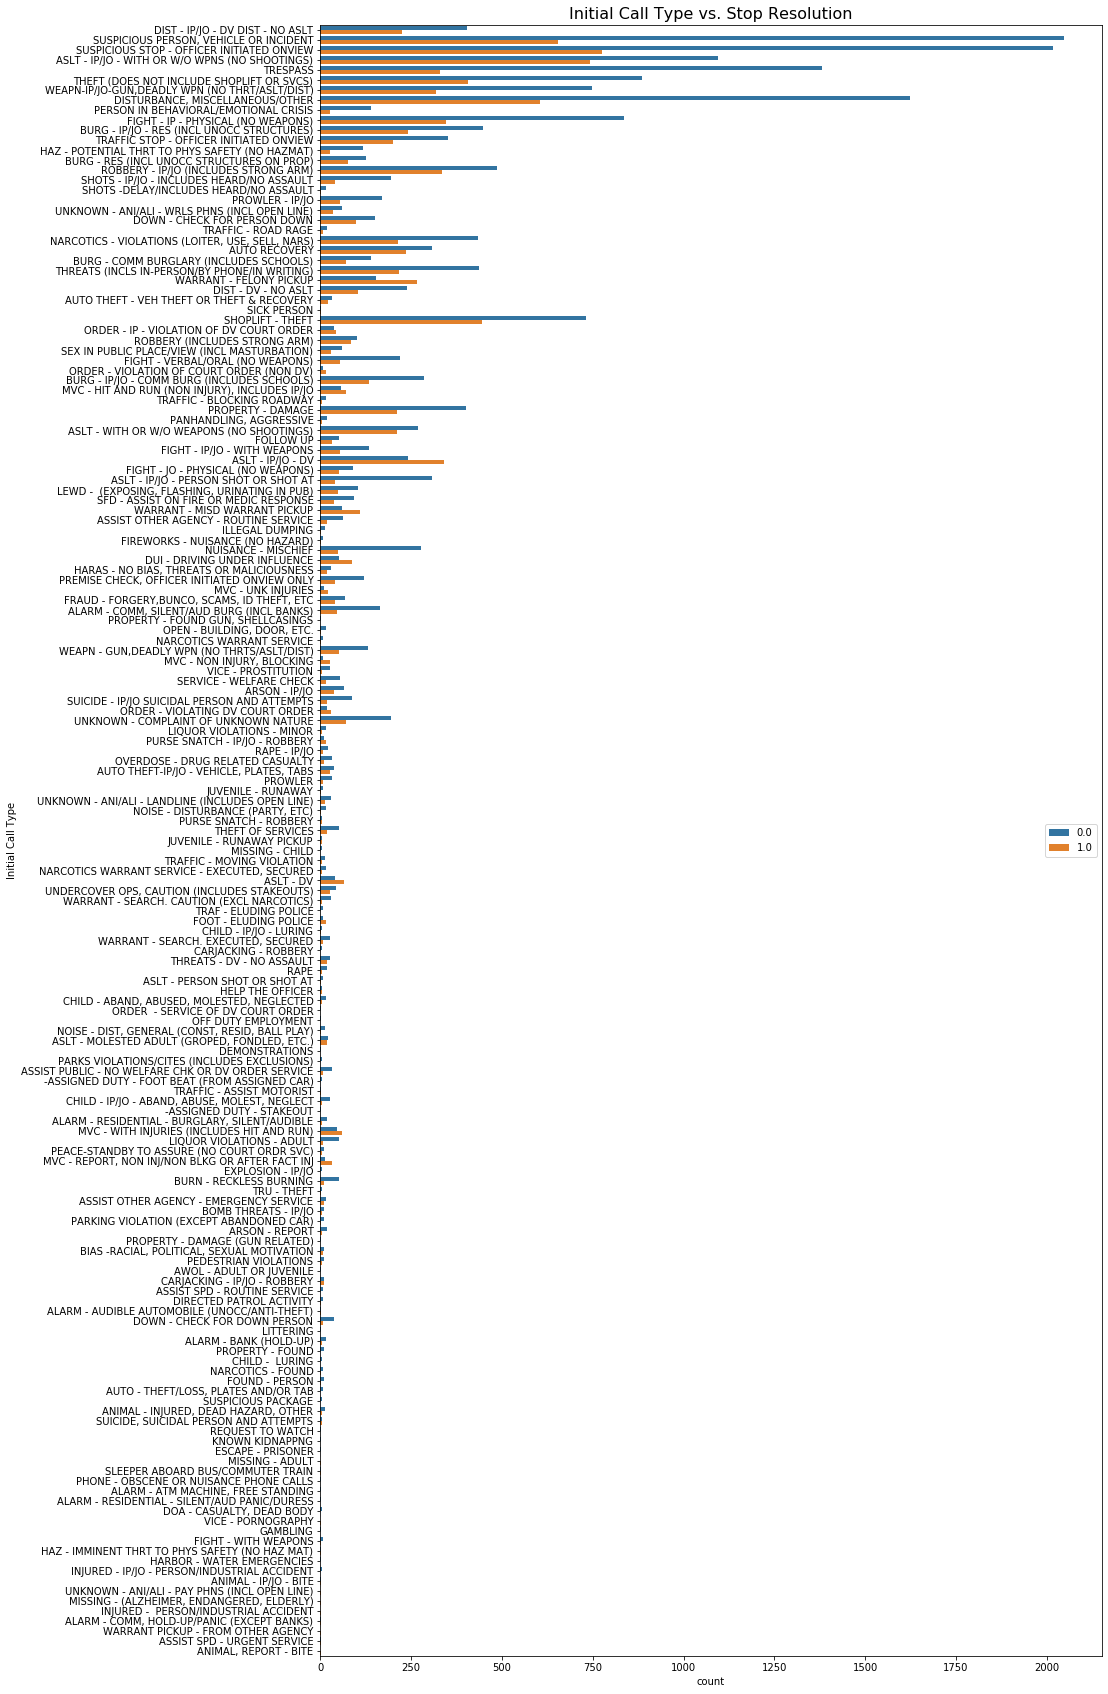

In [80]:
#Plot initial call type vs. stop resolution
initial_call = df[df['Initial Call Type'] != '-']
plt.figure(figsize=(14, 30))
sns.countplot(y=initial_call['Initial Call Type'], hue=df['Stop Resolution'])
plt.title('Initial Call Type vs. Stop Resolution', fontsize=(16))
plt.legend(loc='center right')
plt.show()

In [81]:
#Convert initial call type column to binary
values = df['Initial Call Type'].value_counts(normalize=True)[:30]
values

-                                                   0.289287
SUSPICIOUS STOP - OFFICER INITIATED ONVIEW          0.064976
SUSPICIOUS PERSON, VEHICLE OR INCIDENT              0.062906
DISTURBANCE, MISCELLANEOUS/OTHER                    0.051809
ASLT - IP/JO - WITH OR W/O WPNS (NO SHOOTINGS)      0.042713
TRESPASS                                            0.039805
THEFT (DOES NOT INCLUDE SHOPLIFT OR SVCS)           0.030057
FIGHT - IP - PHYSICAL (NO WEAPONS)                  0.027521
SHOPLIFT - THEFT                                    0.027405
WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/DIST)      0.024799
ROBBERY - IP/JO (INCLUDES STRONG ARM)               0.019123
BURG - IP/JO - RES (INCL UNOCC STRUCTURES)          0.016029
THREATS (INCLS IN-PERSON/BY PHONE/IN WRITING)       0.015215
NARCOTICS - VIOLATIONS (LOITER, USE, SELL, NARS)    0.015075
DIST - IP/JO - DV DIST - NO ASLT                    0.014610
PROPERTY - DAMAGE                                   0.014238
ASLT - IP/JO - DV       

In [82]:
# value_list = values.loc[values > .04].index

# for i in value_list:
#     df['Initial Call Type'].replace(i, 0.0, inplace=True)
# values = df['Initial Call Type'].values
# df['Initial Call Type'] = np.where(values != 0.0, 1.0, 0.0)

In [83]:
values = df['Initial Call Type'].values
df['Initial Call Type'] = np.where(values != '-', 1.0, 0.0)

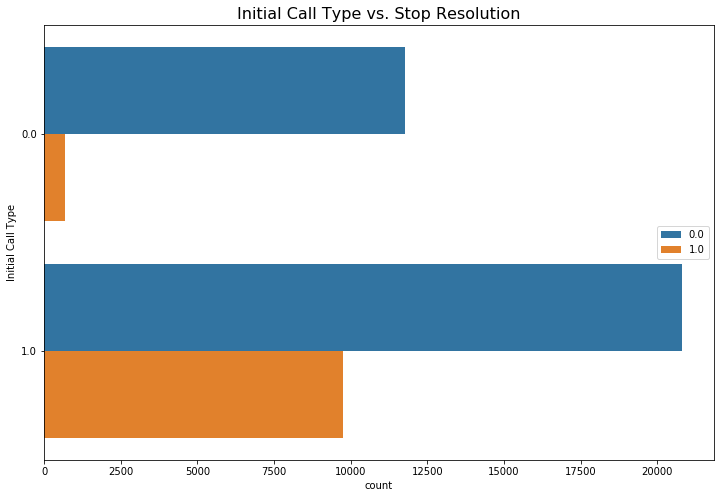

In [84]:
plt.figure(figsize=(12, 8))
sns.countplot(y=df['Initial Call Type'], hue=df['Stop Resolution'])
plt.title('Initial Call Type vs. Stop Resolution', fontsize=(16))
plt.legend(loc='center right')
plt.show()

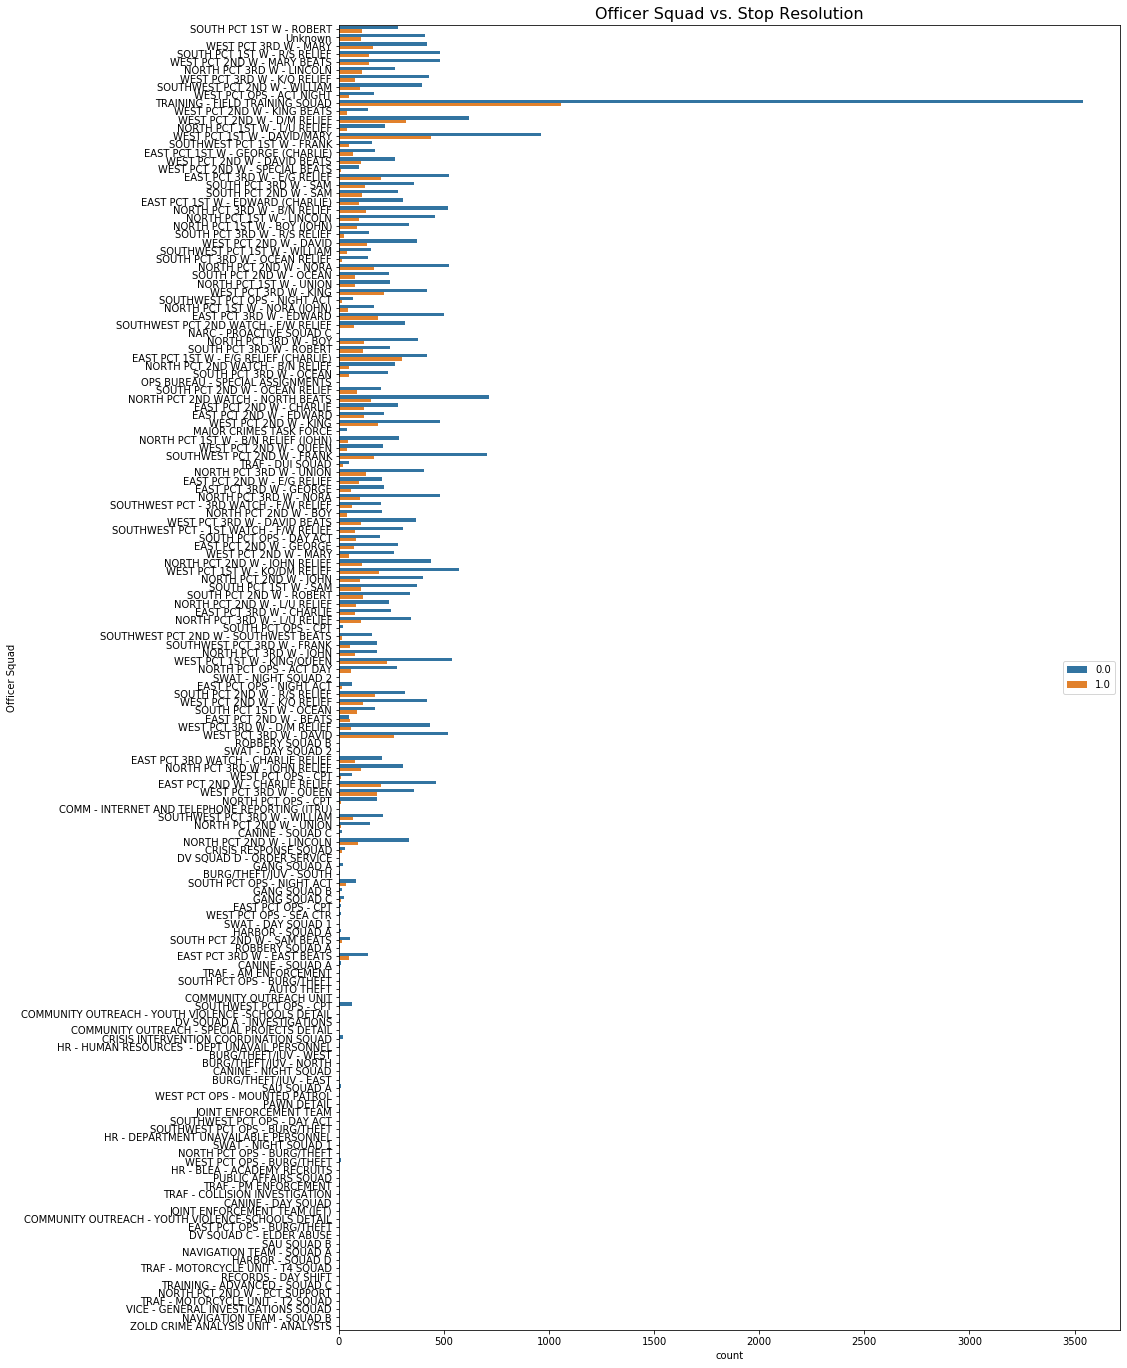

In [85]:
#Plot officer squad vs. stop resolution
plt.figure(figsize=(14, 24))
sns.countplot(y=df['Officer Squad'], hue=df['Stop Resolution'])
plt.title('Officer Squad vs. Stop Resolution', fontsize=(16))
plt.legend(loc='center right')
plt.show()

In [86]:
#Show value distribution of officer squad
values = df['Officer Squad'].value_counts(normalize=True)[:50]
values

TRAINING - FIELD TRAINING SQUAD           0.106898
WEST PCT 1ST W - DAVID/MARY               0.032476
WEST PCT 2ND W - D/M RELIEF               0.021868
SOUTHWEST PCT 2ND W - FRANK               0.020333
NORTH PCT 2ND WATCH - NORTH BEATS         0.020240
WEST PCT 3RD W - DAVID                    0.018169
WEST PCT 1ST W - KING/QUEEN               0.017867
WEST PCT 1ST W - KQ/DM RELIEF             0.017657
EAST PCT 3RD W - E/G RELIEF               0.016890
EAST PCT 1ST W - E/G RELIEF (CHARLIE)     0.016773
EAST PCT 3RD W - EDWARD                   0.016029
NORTH PCT 2ND W - NORA                    0.016006
WEST PCT 2ND W - KING                     0.015494
EAST PCT 2ND W - CHARLIE RELIEF           0.015424
NORTH PCT 3RD W - B/N RELIEF              0.015122
WEST PCT 3RD W - KING                     0.014633
WEST PCT 2ND W - MARY BEATS               0.014470
SOUTH PCT 1ST W - R/S RELIEF              0.014447
WEST PCT 3RD W - MARY                     0.013540
NORTH PCT 3RD W - NORA         

In [87]:
#Bin values for officer squad
df['Officer Squad'] = df['Officer Squad'].map(lambda x: x[0])

In [88]:
#Officer squad value counts
df['Officer Squad'].value_counts(normalize=True)

W    0.272258
N    0.242759
S    0.215703
E    0.141421
T    0.108945
U    0.011958
C    0.002489
G    0.001652
M    0.001024
H    0.000512
B    0.000302
J    0.000233
D    0.000209
A    0.000186
R    0.000140
P    0.000116
O    0.000047
V    0.000023
Z    0.000023
Name: Officer Squad, dtype: float64

In [89]:
#Bin officer squad to N, S, E, W, T (training), Other
values = df['Officer Squad'].value_counts(normalize=True)[:50]
value_list = values.loc[values < .02].index

for i in value_list:
    df['Officer Squad'].replace(i, 'Other', inplace=True)

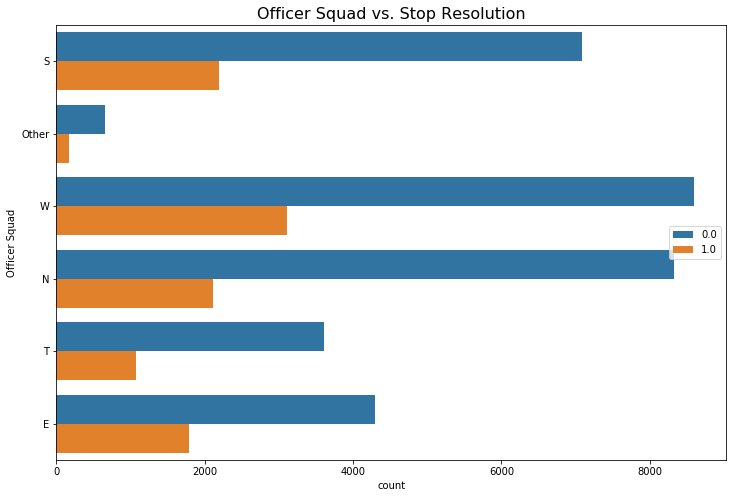

In [90]:
#Plot officer squad vs. stop resolution
plt.figure(figsize=(12, 8))
sns.countplot(y=df['Officer Squad'], hue=df['Stop Resolution'])
plt.title('Officer Squad vs. Stop Resolution', fontsize=(16))
plt.legend(loc='center right')
plt.show()

Dropping reported month column rather than creating dummy variables.

In [91]:
#Drop Reported Month
df = df.drop(columns=['Reported Month'], axis=1)

Dropping Frisk Flag and Weapon Type as these features can only be found during an actual Terry Stop and wouldn't be helpful in predicting arrests at the time of initial suspiscion.

In [92]:
df = df.drop(columns=['Frisk Flag', 'Weapon Type'], axis=1)

In [93]:
#Show column unique value counts
for col in df.columns:
    print(col, df[col].nunique())

Subject Age Group 7
Stop Resolution 2
Officer YOB 51
Officer Gender 2
Officer Race 2
Subject Perceived Race 2
Subject Perceived Gender 2
Initial Call Type 2
Call Type 3
Officer Squad 6
Beat 2
Reported Day of Week 7
Reported Year 6
Reported Day 31
Reported Hour 24
Reported Minute 60


In [94]:
#Convert categorical variables to dummies
df = pd.get_dummies(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42985 entries, 0 to 44042
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Stop Resolution                 42985 non-null  float64
 1   Officer YOB                     42985 non-null  int64  
 2   Officer Gender                  42985 non-null  float64
 3   Officer Race                    42985 non-null  float64
 4   Subject Perceived Race          42985 non-null  float64
 5   Subject Perceived Gender        42985 non-null  float64
 6   Initial Call Type               42985 non-null  float64
 7   Beat                            42985 non-null  float64
 8   Reported Year                   42985 non-null  int64  
 9   Reported Day                    42985 non-null  int64  
 10  Reported Hour                   42985 non-null  float64
 11  Reported Minute                 42985 non-null  float64
 12  Subject Age Group_-             

In [95]:
#View value counts of target variable
df['Stop Resolution'].value_counts()

0.0    32554
1.0    10431
Name: Stop Resolution, dtype: int64

We will begin building different models utilizing multiple classification algorithms and comparing scores. The ultimate goal is predicting arrests while minimizing false negatives, so our scoring will be focused on recall/sensitivity: measuring the proportion of positives that are correctly identified.

# Model 1: Logistic Regression

In [96]:
#Split features and target
X = df.drop(columns=['Stop Resolution'], axis=1)
y = df['Stop Resolution']

#Create function to easily build models and display results
def build_model(classifier, predictors, labels):
    '''Build classification model, returning classification report, train and test accuracy, and confusion matrix.
    
    Keyword arguments: 
    classifier -- classification algorithm
    predictors -- X, features
    labels -- y, target
    '''
    
    #Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=123)
    
    #Scale the data
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    #Create variables that can be called outside function
    build_model.X_train = X_train
    build_model.X_test = X_test
    build_model.y_train = y_train
    build_model.y_test = y_test
    
    #Fit model
    model = classifier.fit(X_train, y_train)
    score = np.mean(cross_val_score(classifier, X, y, cv=5, scoring='recall'))
    
    #Create predictions
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)
    
    #Create variables that can be called outside function
    build_model.y_hat_train = y_hat_train
    build_model.y_hat_test = y_hat_test
    
    #Print classification report
    print('Train Classification Report\n', classification_report(y_train, y_hat_train))
    print('\n----------------------------------\n')
    print('Test Classification Report\n', classification_report(y_test, y_hat_test))
    print('\n----------------------------------\n')
    
    print('Train Accuracy:', round(accuracy_score(y_train, y_hat_train), 3))
    print('Test Accuracy:', round(accuracy_score(y_test, y_hat_test), 3))
    print('Cross Validation Recall', round(score, 3))
    print('\n----------------------------------\n')
    
    #Create a results dataframe
    results = pd.DataFrame([[str(model), round(accuracy_score(y_train, y_hat_train), 3), 
                             round(accuracy_score(y_test, y_hat_test), 3), round(score, 3)]], 
                          columns=['Model', 'Train_Accuracy', 'Test_Accuracy', 'Cross_Val_Recall'])
    build_model.results = results
    
    #Plot Confusion Matrices
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
    plot_confusion_matrix(classifier, X_train, y_train,
                     cmap=plt.cm.Blues, ax=axes[0])
    fig.suptitle('Train & Test Confusion Matrices', fontsize=16);
    
    plot_confusion_matrix(classifier, X_test, y_test,
                     cmap=plt.cm.Blues, ax=axes[1])
    plt.subplots_adjust(wspace=0.4)
    return model

Train Classification Report
               precision    recall  f1-score   support

         0.0       0.76      1.00      0.86     26059
         1.0       0.00      0.00      0.00      8329

    accuracy                           0.76     34388
   macro avg       0.38      0.50      0.43     34388
weighted avg       0.57      0.76      0.65     34388


----------------------------------

Test Classification Report
               precision    recall  f1-score   support

         0.0       0.76      1.00      0.86      6495
         1.0       0.00      0.00      0.00      2102

    accuracy                           0.76      8597
   macro avg       0.38      0.50      0.43      8597
weighted avg       0.57      0.76      0.65      8597


----------------------------------

Train Accuracy: 0.758
Test Accuracy: 0.755
Cross Validation Recall 0.034

----------------------------------



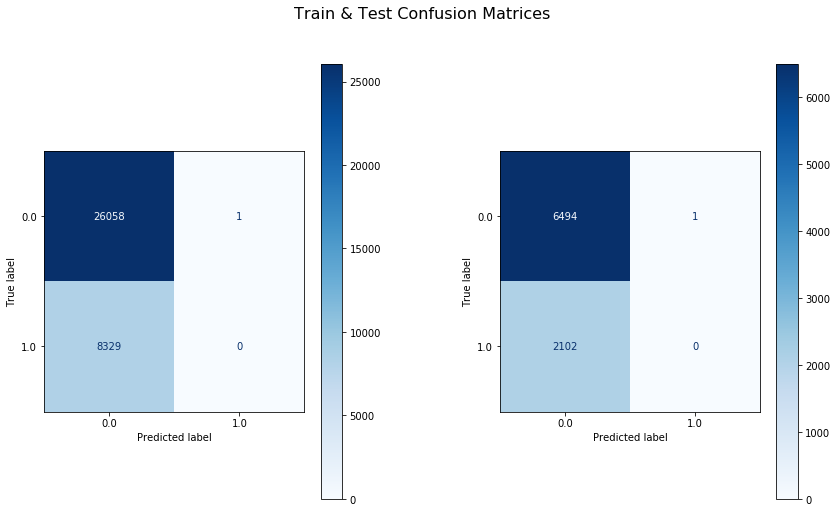

In [97]:
model = build_model(LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear', random_state=123), X, y)
model1_results = build_model.results

# Model 2: Multinomial Bayes

Train Classification Report
               precision    recall  f1-score   support

         0.0       0.76      1.00      0.86     26059
         1.0       0.00      0.00      0.00      8329

    accuracy                           0.76     34388
   macro avg       0.38      0.50      0.43     34388
weighted avg       0.57      0.76      0.65     34388


----------------------------------

Test Classification Report
               precision    recall  f1-score   support

         0.0       0.76      1.00      0.86      6495
         1.0       0.00      0.00      0.00      2102

    accuracy                           0.76      8597
   macro avg       0.38      0.50      0.43      8597
weighted avg       0.57      0.76      0.65      8597


----------------------------------

Train Accuracy: 0.758
Test Accuracy: 0.755
Cross Validation Recall 0.245

----------------------------------



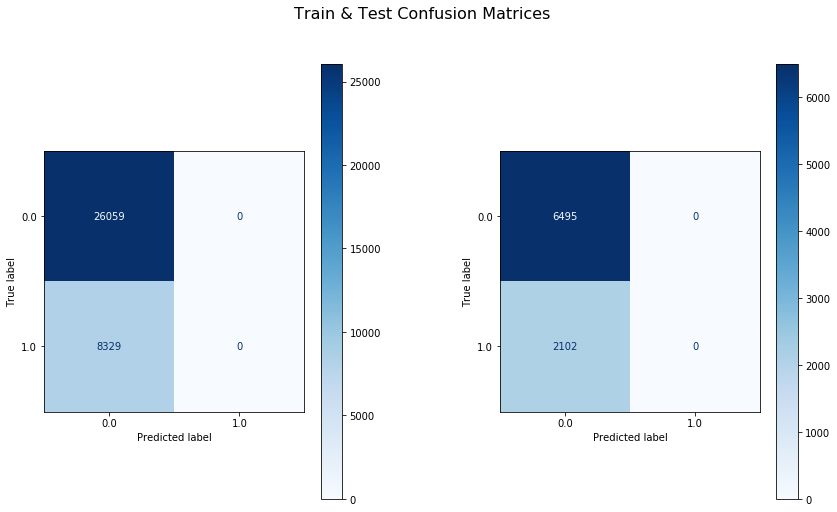

In [98]:
import warnings
warnings.filterwarnings('ignore')
model = build_model(MultinomialNB(), X, y)
model2_results = build_model.results

# Model 3: Decision Tree

Train Classification Report
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     26059
         1.0       1.00      1.00      1.00      8329

    accuracy                           1.00     34388
   macro avg       1.00      1.00      1.00     34388
weighted avg       1.00      1.00      1.00     34388


----------------------------------

Test Classification Report
               precision    recall  f1-score   support

         0.0       0.80      0.79      0.80      6495
         1.0       0.39      0.40      0.40      2102

    accuracy                           0.70      8597
   macro avg       0.60      0.60      0.60      8597
weighted avg       0.70      0.70      0.70      8597


----------------------------------

Train Accuracy: 1.0
Test Accuracy: 0.697
Cross Validation Recall 0.443

----------------------------------



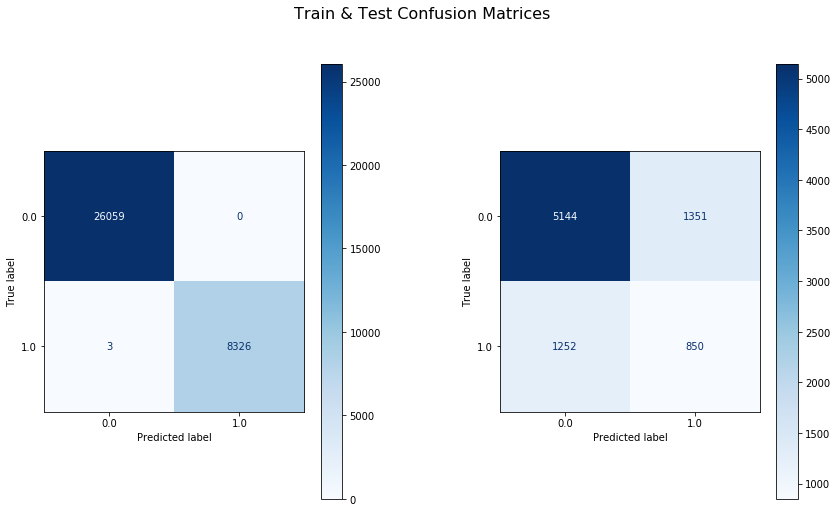

In [99]:
model = build_model(DecisionTreeClassifier(random_state=123), X, y)
model3_results = build_model.results

# Model 4: Random Forest

Train Classification Report
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     26059
         1.0       1.00      1.00      1.00      8329

    accuracy                           1.00     34388
   macro avg       1.00      1.00      1.00     34388
weighted avg       1.00      1.00      1.00     34388


----------------------------------

Test Classification Report
               precision    recall  f1-score   support

         0.0       0.79      0.96      0.86      6495
         1.0       0.62      0.19      0.29      2102

    accuracy                           0.77      8597
   macro avg       0.70      0.57      0.57      8597
weighted avg       0.74      0.77      0.72      8597


----------------------------------

Train Accuracy: 1.0
Test Accuracy: 0.773
Cross Validation Recall 0.304

----------------------------------



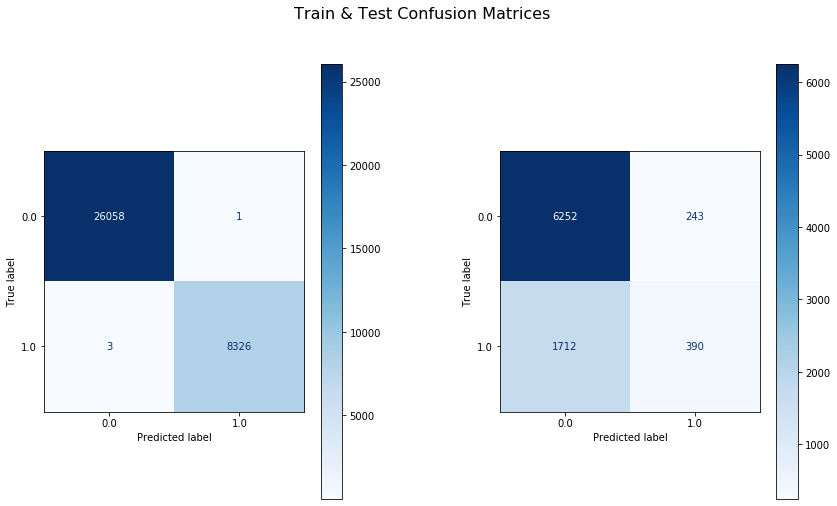

In [100]:
model = build_model(RandomForestClassifier(random_state=123), X, y)
model4_results = build_model.results

Using a balanced random forest to attempt to fix the clear class imbalance issue and add a min_samples_leaf parameter to reduce overfitting.

# Model 5: Balanced Random Forest

Train Classification Report
               precision    recall  f1-score   support

         0.0       0.95      0.53      0.68     26059
         1.0       0.38      0.91      0.54      8329

    accuracy                           0.62     34388
   macro avg       0.67      0.72      0.61     34388
weighted avg       0.81      0.62      0.65     34388


----------------------------------

Test Classification Report
               precision    recall  f1-score   support

         0.0       0.92      0.50      0.65      6495
         1.0       0.36      0.86      0.50      2102

    accuracy                           0.59      8597
   macro avg       0.64      0.68      0.58      8597
weighted avg       0.78      0.59      0.61      8597


----------------------------------

Train Accuracy: 0.624
Test Accuracy: 0.588
Cross Validation Recall 0.673

----------------------------------



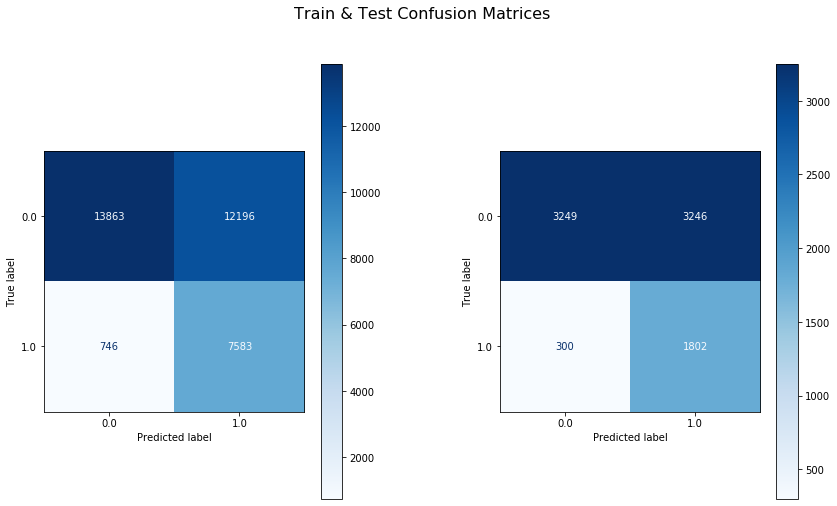

In [101]:
model = build_model(BalancedRandomForestClassifier(min_samples_leaf=10, random_state=123), X, y)
model5_results = build_model.results

Our recall went up significantly as a result of this model. We will continue looking at other models, but will come back to tuning a random forest model to see if we can increase the recall score.

# Model 6: Bagging with Decision Tree

Train Classification Report
               precision    recall  f1-score   support

         0.0       0.78      0.99      0.88     26059
         1.0       0.82      0.15      0.25      8329

    accuracy                           0.79     34388
   macro avg       0.80      0.57      0.56     34388
weighted avg       0.79      0.79      0.72     34388


----------------------------------

Test Classification Report
               precision    recall  f1-score   support

         0.0       0.77      0.98      0.86      6495
         1.0       0.53      0.09      0.15      2102

    accuracy                           0.76      8597
   macro avg       0.65      0.53      0.50      8597
weighted avg       0.71      0.76      0.68      8597


----------------------------------

Train Accuracy: 0.786
Test Accuracy: 0.758
Cross Validation Recall 0.295

----------------------------------



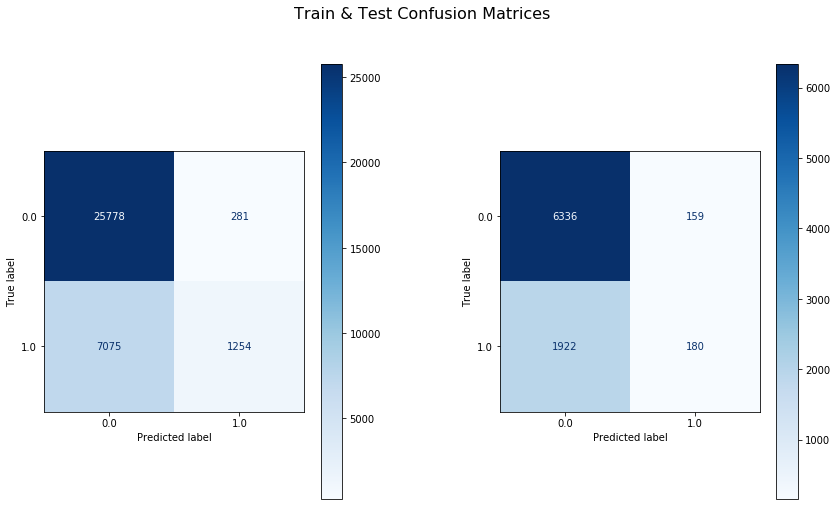

In [102]:
model = build_model(BaggingClassifier(DecisionTreeClassifier(max_depth=10, random_state=123)), X, y)
model6_results = build_model.results

# Model 7: Balanced Bagging with Decision Tree

Train Classification Report
               precision    recall  f1-score   support

         0.0       0.94      0.54      0.68     26059
         1.0       0.38      0.90      0.54      8329

    accuracy                           0.62     34388
   macro avg       0.66      0.72      0.61     34388
weighted avg       0.81      0.62      0.65     34388


----------------------------------

Test Classification Report
               precision    recall  f1-score   support

         0.0       0.90      0.51      0.65      6495
         1.0       0.35      0.83      0.50      2102

    accuracy                           0.59      8597
   macro avg       0.63      0.67      0.57      8597
weighted avg       0.77      0.59      0.61      8597


----------------------------------

Train Accuracy: 0.624
Test Accuracy: 0.588
Cross Validation Recall 0.633

----------------------------------



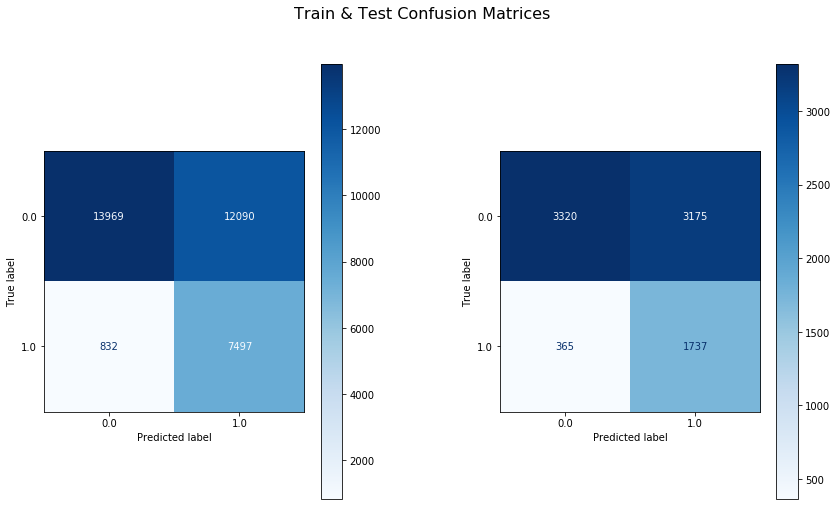

In [103]:
model = build_model(BalancedBaggingClassifier(DecisionTreeClassifier(max_depth=9, 
                                                                     random_state=123)), 
                    X, y)
model7_results = build_model.results

# Model 8: AdaBoost

Train Classification Report
               precision    recall  f1-score   support

         0.0       0.76      1.00      0.86     26059
         1.0       0.60      0.01      0.01      8329

    accuracy                           0.76     34388
   macro avg       0.68      0.50      0.44     34388
weighted avg       0.72      0.76      0.66     34388


----------------------------------

Test Classification Report
               precision    recall  f1-score   support

         0.0       0.76      1.00      0.86      6495
         1.0       0.56      0.00      0.01      2102

    accuracy                           0.76      8597
   macro avg       0.66      0.50      0.44      8597
weighted avg       0.71      0.76      0.65      8597


----------------------------------

Train Accuracy: 0.758
Test Accuracy: 0.756
Cross Validation Recall 0.247

----------------------------------



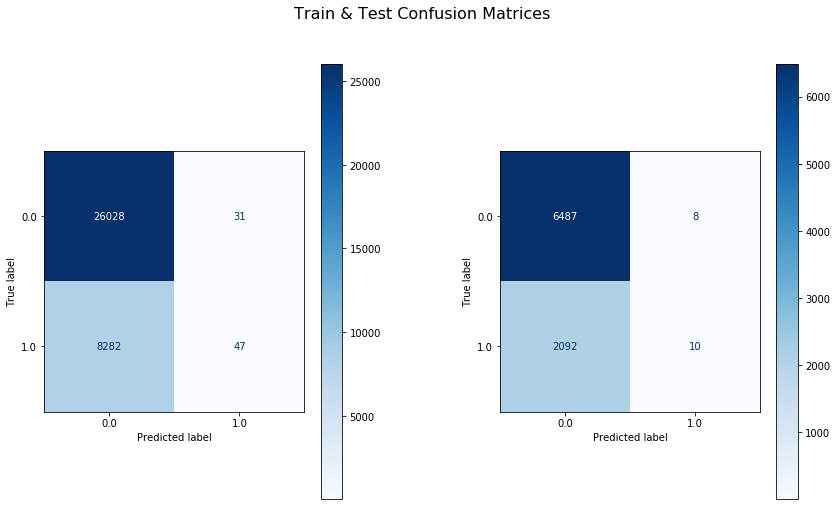

In [104]:
model = build_model(AdaBoostClassifier(random_state=123), X, y)
model8_results = build_model.results

# Model 9: XGBoost

Train Classification Report
               precision    recall  f1-score   support

         0.0       0.76      1.00      0.86     26059
         1.0       0.00      0.00      0.00      8329

    accuracy                           0.76     34388
   macro avg       0.38      0.50      0.43     34388
weighted avg       0.57      0.76      0.65     34388


----------------------------------

Test Classification Report
               precision    recall  f1-score   support

         0.0       0.76      1.00      0.86      6495
         1.0       1.00      0.00      0.00      2102

    accuracy                           0.76      8597
   macro avg       0.88      0.50      0.43      8597
weighted avg       0.82      0.76      0.65      8597


----------------------------------

Train Accuracy: 0.758
Test Accuracy: 0.756
Cross Validation Recall 0.33

----------------------------------



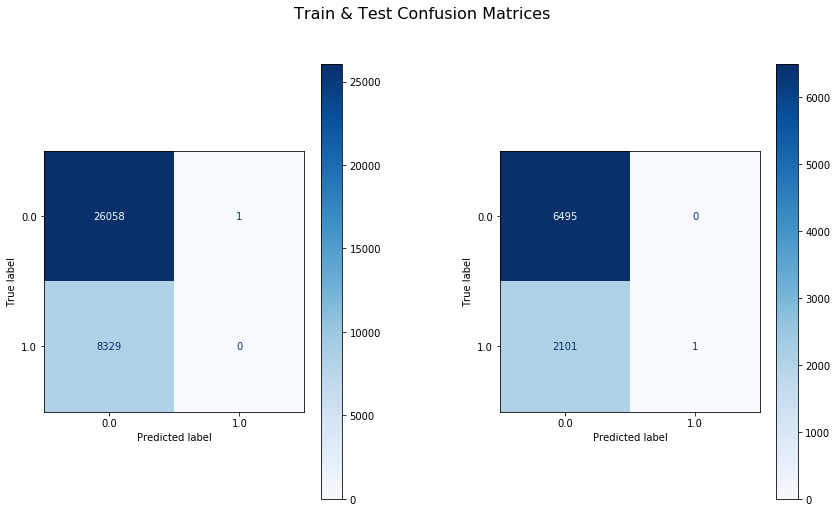

In [105]:
model = build_model(xgboost.XGBClassifier(random_state=123), X, y)
model9_results = build_model.results

We will attempt to fix the class imbalance issue with XGBoost and tune our hyperparameters for an optimal recall score.

# Model 10: XGBoost with Hyperparameter Tuning

In [106]:
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [1, 2, 3],
    'n_estimators': [50, 100],
    'scale_pos_weight': [5]
}

In [107]:
grid_clf = GridSearchCV(xgboost.XGBClassifier(random_state=123), param_grid=param_grid, scoring='recall', 
                        cv=3, n_jobs=1, return_train_score=True)
grid_clf.fit(build_model.X_train, build_model.y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))
    
# Mean training score
gs_training_score = np.mean(grid_clf.cv_results_['mean_train_score'])

# Mean test score
gs_testing_score = grid_clf.score(build_model.X_test, build_model.y_test)

print(f"Mean Training Score: {gs_training_score :.2%}")
print(f"Mean Test Score: {gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
grid_clf.best_params_

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 2
n_estimators: 50
scale_pos_weight: 5
Mean Training Score: 94.40%
Mean Test Score: 96.00%
Best Parameter Combination Found During Grid Search:


{'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 50,
 'scale_pos_weight': 5}

Now building model with the new parameters.

Train Classification Report
               precision    recall  f1-score   support

         0.0       0.96      0.34      0.50     26059
         1.0       0.32      0.95      0.47      8329

    accuracy                           0.49     34388
   macro avg       0.64      0.65      0.49     34388
weighted avg       0.80      0.49      0.49     34388


----------------------------------

Test Classification Report
               precision    recall  f1-score   support

         0.0       0.96      0.33      0.49      6495
         1.0       0.32      0.96      0.48      2102

    accuracy                           0.48      8597
   macro avg       0.64      0.65      0.48      8597
weighted avg       0.80      0.48      0.49      8597


----------------------------------

Train Accuracy: 0.486
Test Accuracy: 0.484
Cross Validation Recall 0.941

----------------------------------



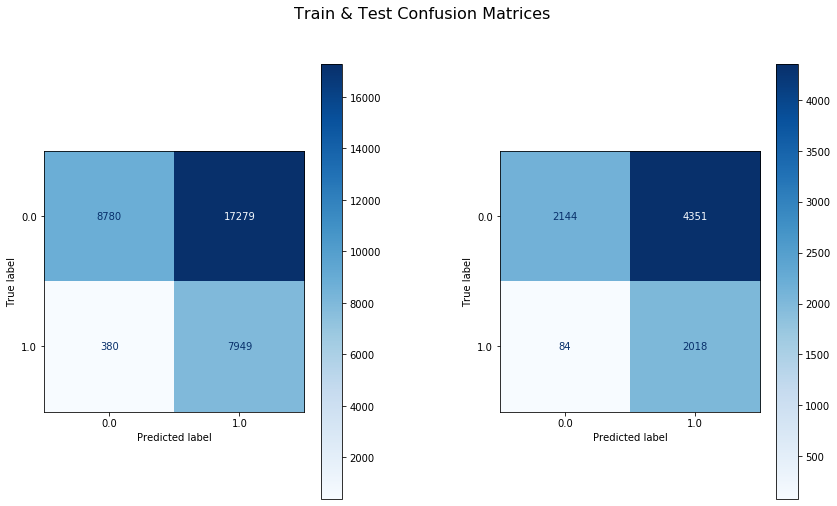

In [108]:
model = build_model(xgboost.XGBClassifier(learning_rate=0.1, max_depth=2, n_estimators=50, 
                                          scale_pos_weight=5, random_state=123), X, y)
model10_results = build_model.results

As a result of this model, our recall score has significantly increased to 94.1%, but our accuracy is below 50% for both train and test sets. Below are the feature importances of this model.

In [109]:
#Create feature importance dataframe
xg_features = pd.DataFrame(model.feature_importances_, X.columns, columns=['importance'])
xg_features = xg_features.sort_values(by=['importance'], ascending=False)
xg_features

,importance
Beat,0.559246
Initial Call Type,0.128816
Officer Squad_N,0.034205
Call Type_Other,0.034097
Officer YOB,0.032449
Reported Year,0.030069
Subject Age Group_-,0.024243
Reported Hour,0.019957
Officer Squad_W,0.019055
Officer Squad_T,0.017952


There are several features that virtually do not contribute to the model. Rather than just removing these features, we will use the Boruta algorithm combined with a random forest model for feature selection. The Boruta algorithm creates a dataframe combining our original dataframe with new columns of our features randomly shuffled, comparing the feature importance threshold of our original features with these permuted features. The feature is selected if it performs better than the highest randomized version of that feature. We will iterate through this process with a max_iter of 100, and a binomial distribution is created determining which features we can keep along with which features the algorithm is indecisive about that we can arbitrarily choose to keep or not.  

# Model 11: Feature Selection with Boruta and Random Forest

In [110]:
#Use Boruta algorithm with random forest for feature selection
forest = RandomForestClassifier( 
   random_state=123, max_depth = 10, min_samples_leaf=3, class_weight={0:1, 1:4}
)
boruta = BorutaPy(
    random_state = 123, 
    estimator = forest, 
    n_estimators = 'auto',
    max_iter = 100 # number of trials to perform
)

In [111]:
#Fit the model
boruta.fit(np.array(X), np.array(y))

BorutaPy(estimator=RandomForestClassifier(class_weight={0: 1, 1: 4},
                                          max_depth=10, min_samples_leaf=3,
                                          n_estimators=40,
                                          random_state=<mtrand.RandomState object at 0x7f9e185e8510>),
         n_estimators='auto',
         random_state=<mtrand.RandomState object at 0x7f9e185e8510>)

In [112]:
#Establish features to keep and features that are questionable
green_area = X.columns[boruta.support_].to_list()
blue_area = X.columns[boruta.support_weak_].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)

features in the green area: ['Officer YOB', 'Initial Call Type', 'Beat', 'Reported Year', 'Reported Minute', 'Call Type_911', 'Call Type_Other']
features in the blue area: []


In [113]:
#Split new features and target
X = df[green_area]
y = df['Stop Resolution']

With this model, we will use a class_weight parameter to balance the classes with {0:1, 1:5}. This will give weight to arrests and increase our recall score.

In [114]:
#Create parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['gini'],
    'class_weight': [{0:1, 1:5}],
    'max_depth': [4, 5, 6],
    'min_samples_leaf': [2, 3], 
    'n_estimators': [50, 100]
}

Train Classification Report
               precision    recall  f1-score   support

         0.0       0.95      0.37      0.54     26059
         1.0       0.32      0.94      0.48      8329

    accuracy                           0.51     34388
   macro avg       0.64      0.66      0.51     34388
weighted avg       0.80      0.51      0.52     34388


----------------------------------

Test Classification Report
               precision    recall  f1-score   support

         0.0       0.94      0.36      0.52      6495
         1.0       0.32      0.93      0.48      2102

    accuracy                           0.50      8597
   macro avg       0.63      0.65      0.50      8597
weighted avg       0.79      0.50      0.51      8597


----------------------------------

Train Accuracy: 0.51
Test Accuracy: 0.501
Cross Validation Recall 0.938

----------------------------------

Grid Search found the following optimal parameters: 
class_weight: {0: 1, 1: 5}
criterion: 'gini'
max_dept

{'class_weight': {0: 1, 1: 5},
 'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 3,
 'n_estimators': 100}

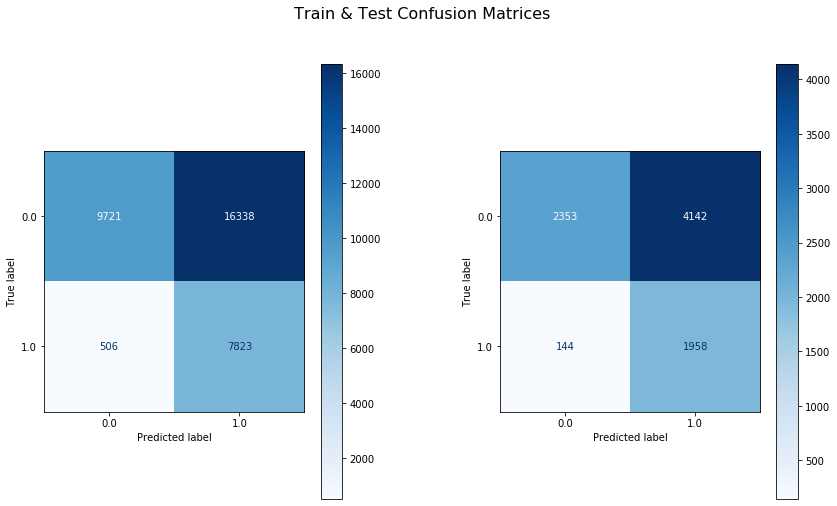

In [115]:
#Use Gridsearch for hyperparameter tuning and print results
grid_clf = GridSearchCV(RandomForestClassifier(random_state=123), param_grid=param_grid, scoring='recall', 
                        cv=3, n_jobs=1, return_train_score=True)
grid_clf = build_model(grid_clf, X, y)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))
    
# Mean training score
rf_gs_training_score = np.mean(grid_clf.cv_results_['mean_train_score'])

# Mean test score
rf_gs_testing_score = grid_clf.score(build_model.X_test, build_model.y_test)

print(f"Mean Training Score: {rf_gs_training_score :.2%}")
print(f"Mean Test Score: {rf_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
grid_clf.best_params_

Now building the random forest model with selected parameters.

Train Classification Report
               precision    recall  f1-score   support

         0.0       0.95      0.37      0.54     26059
         1.0       0.32      0.94      0.48      8329

    accuracy                           0.51     34388
   macro avg       0.64      0.66      0.51     34388
weighted avg       0.80      0.51      0.52     34388


----------------------------------

Test Classification Report
               precision    recall  f1-score   support

         0.0       0.94      0.36      0.52      6495
         1.0       0.32      0.93      0.48      2102

    accuracy                           0.50      8597
   macro avg       0.63      0.65      0.50      8597
weighted avg       0.79      0.50      0.51      8597


----------------------------------

Train Accuracy: 0.51
Test Accuracy: 0.501
Cross Validation Recall 0.937

----------------------------------



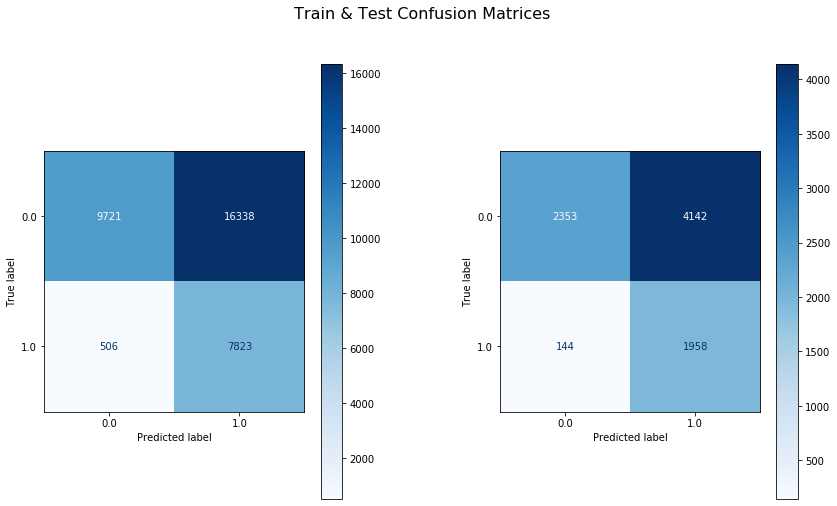

In [116]:
rf_model = build_model(RandomForestClassifier(random_state=123, criterion='gini', class_weight={0:1,1:5}, 
                                              max_depth=6, min_samples_leaf=3, n_estimators=100), X, y)
model11_results = build_model.results

Our recall score is at 93.7% with both train and test accuracy above 50%. Let's build our XGBoost model again with these features and adjusting max_depth to 4 and our learning rate to 0.01.

In [117]:
#Split features and target
X = df[green_area]
y = df['Stop Resolution']

Train Classification Report
               precision    recall  f1-score   support

         0.0       0.95      0.36      0.53     26059
         1.0       0.32      0.94      0.48      8329

    accuracy                           0.50     34388
   macro avg       0.64      0.65      0.50     34388
weighted avg       0.80      0.50      0.52     34388


----------------------------------

Test Classification Report
               precision    recall  f1-score   support

         0.0       0.95      0.36      0.52      6495
         1.0       0.32      0.94      0.48      2102

    accuracy                           0.50      8597
   macro avg       0.63      0.65      0.50      8597
weighted avg       0.79      0.50      0.51      8597


----------------------------------

Train Accuracy: 0.504
Test Accuracy: 0.498
Cross Validation Recall 0.954

----------------------------------



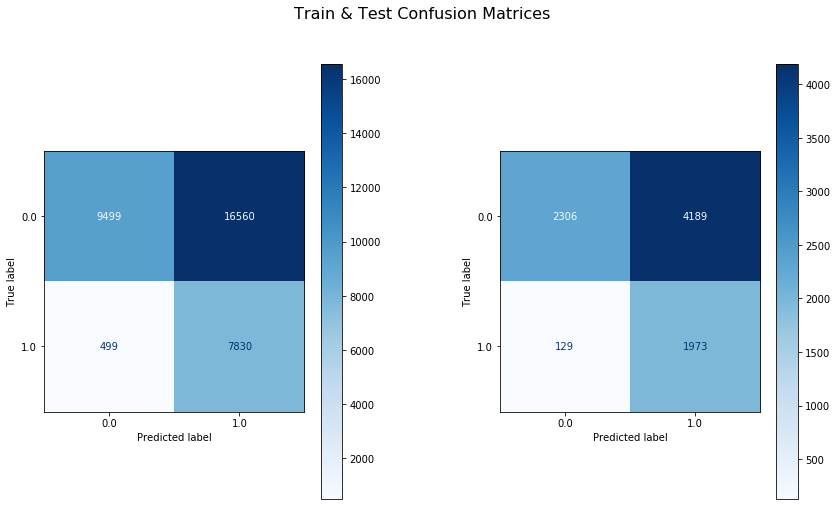

In [118]:
xg_model = build_model(xgboost.XGBClassifier(learning_rate=0.01, max_depth=4, n_estimators=50, 
                                          scale_pos_weight=5, random_state=123), X, y)
plt.savefig('Images/final_model_results.png')
model12_results = build_model.results

Our recall score is 95.4%, higher than our random forest model. With a train score of 50.4% and test score of 49.8% we will use this as our final model.

In [119]:
#Plot feature importance
xg_features = pd.DataFrame(xg_model.feature_importances_, X.columns, columns=['importance'])
xg_features = xg_features.sort_values(by=['importance'], ascending=False)
xg_features

,importance
Beat,0.890335
Initial Call Type,0.085654
Officer YOB,0.008826
Call Type_911,0.007603
Reported Year,0.006476
Reported Minute,0.001106
Call Type_Other,0.000000


Below is a dataframe of results from all models.

In [120]:
#Create results dataframe with all models built
results = pd.concat([model1_results, model2_results, model3_results, model4_results, 
                     model5_results, model6_results, model7_results, model8_results, 
                     model9_results, model10_results, model11_results, model12_results],
                    ignore_index=True)
results

,Model,Train_Accuracy,Test_Accuracy,Cross_Val_Recall
0,"LogisticRegression(C=1000000000000.0, fit_inte...",0.758,0.755,0.034
1,MultinomialNB(),0.758,0.755,0.245
2,DecisionTreeClassifier(random_state=123),1.000,0.697,0.443
3,RandomForestClassifier(random_state=123),1.000,0.773,0.304
4,BalancedRandomForestClassifier(min_samples_lea...,0.624,0.588,0.673
5,BaggingClassifier(base_estimator=DecisionTreeC...,0.786,0.758,0.295
6,BalancedBaggingClassifier(base_estimator=Decis...,0.624,0.588,0.633
7,AdaBoostClassifier(random_state=123),0.758,0.756,0.247
8,XGBClassifier(random_state=123),0.758,0.756,0.330
9,"XGBClassifier(max_depth=2, n_estimators=50, ra...",0.486,0.484,0.941


# Conclusion: Interpreting our Final Model

Using features selected from the Boruta algorithm and fitting our model with the XGBoost algorithm with hyperparameter tuning, our model result has a recall score of 95.4% while maintaining approximately 50% accuracy overall for both train and test data. Ultimately, our goal was to focus on recall and predict the highest amount of arrests along with minimizing false negatives, while at the same time maintaining an accuracy above 50%. This result could potentially contribute to reducing the amount of unecessary Terry Stops. Further investigation could include making this a multi-classification problem and predicting whether the result of the Terry Stop was an arrest, offense report, citation/infraction, the suspect was referred for prosecution, or just field contact. Additionally, one could investigate if race and gender have a significant impact on whether a suspect is arrested or not. The final features determining our model results are below with Beat being our feature with the highest importance.

- Beat (whether the address associated with the underlying Computer Aided Dispatch (CAD) event was reported or not)
- Initial Call Type (whether an initial call type was reported or not)
- Call Type_911 (call received by the communication center by dialing 911)
- Call Type_Other (call type that was either not reported or an alternative to onview stops and 911 calls)
- Officer YOB
- Reported Year
- Reported Minute

Important note: although Reported Minute and Call Type Other seem to not have any importance as a result of our model, these features do in fact impact our recall score when including them.

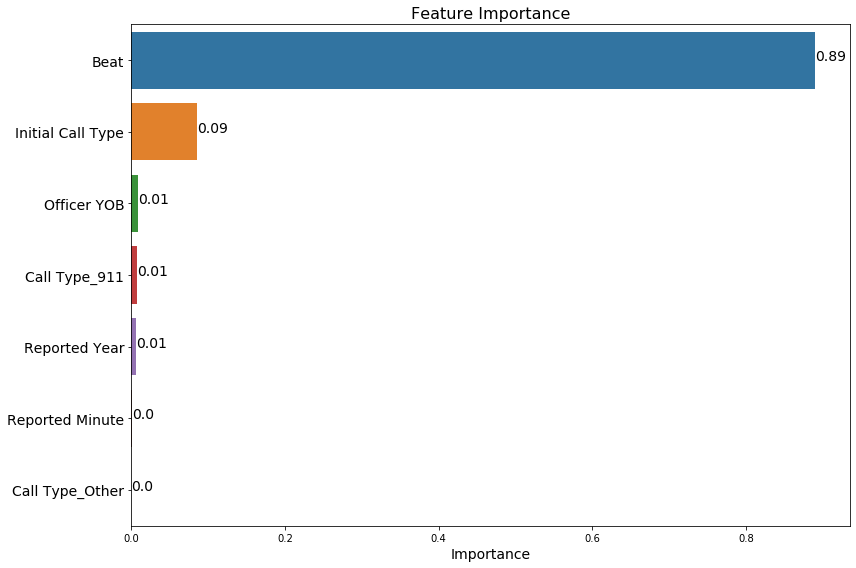

In [121]:
#Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(y=xg_features.index, x=xg_features['importance'])
plt.title('Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.yticks(fontsize=14)
for ind, val in enumerate(xg_features['importance']):
    plt.text(x=val, y=ind, s=round(val, 2), fontsize=14)
plt.tight_layout()
plt.savefig('Images/final_features.png')
plt.show()

# Testing the Final Model

In [122]:
def predict_arrests():
    '''Predict whether a stop resolution will result in an arrest using previously built classification model.
    
    Parameters: Input by User'''
    
    Beat = input("Was the address (beat) associated with the underlying Computer Aided Dispatch (CAD) event reported ? (1=yes, 0=no) ")
    Initial_Call_Type = input("Was an initial call type reported? (1=yes, 0=no) ")
    Call_Type_911 = input("Was the report of suspiscion a 911 call? (1=yes, 0=no) ")
    Call_Type_Other = input("Was the report of suspiscion an alternative to a 911 call or onsite viewing? (1=yes, 0=no) ")
    Officer_YOB = input("What year was the officer born? ")
    Reported_Year = input("What is the reported year? ")
    Reported_Minute = input("What is the reported minute? (1 to 59) ")
    
    features = np.array([[Beat, Initial_Call_Type, Call_Type_911, Call_Type_Other, Officer_YOB, Reported_Year, 
                        Reported_Minute]], dtype=float)
    
    result = xg_model.predict(features)
    if result == 1:
        answer = 'Yes'
    else:
        answer = 'No'
    
    print("\nShould officer conduct a Terry Stop? ")
    return answer

In [123]:
final_df = X.merge(df['Stop Resolution'], how='left', on=X.index)
final_df = final_df.drop(columns=['key_0'], axis=1)

In [124]:
final_df[final_df['Stop Resolution'] == 1].head()

,Officer YOB,Initial Call Type,Beat,Reported Year,Reported Minute,Call Type_911,Call Type_Other,Stop Resolution
0,1984,0.0,1.0,2015,32.0,0,1,1.0
65,1959,1.0,1.0,2015,42.0,0,0,1.0
69,1970,1.0,1.0,2015,47.0,1,0,1.0
70,1970,1.0,1.0,2015,57.0,1,0,1.0
74,1967,1.0,1.0,2015,8.0,1,0,1.0


In [125]:
predict_arrests()

Was the address (beat) associated with the underlying Computer Aided Dispatch (CAD) event reported ? (1=yes, 0=no) 1
Was an initial call type reported? (1=yes, 0=no) 0
Was the report of suspiscion a 911 call? (1=yes, 0=no) 0
Was the report of suspiscion an alternative to a 911 call or onsite viewing? (1=yes, 0=no) 1
What year was the officer born? 1984
What is the reported year? 2015
What is the reported minute? (1 to 59) 32

Should officer conduct a Terry Stop? 


'Yes'

In [126]:
predict_arrests()

Was the address (beat) associated with the underlying Computer Aided Dispatch (CAD) event reported ? (1=yes, 0=no) 1
Was an initial call type reported? (1=yes, 0=no) 1
Was the report of suspiscion a 911 call? (1=yes, 0=no) 0
Was the report of suspiscion an alternative to a 911 call or onsite viewing? (1=yes, 0=no) 0
What year was the officer born? 1959
What is the reported year? 2015
What is the reported minute? (1 to 59) 42

Should officer conduct a Terry Stop? 


'Yes'